In [1]:

import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

import math

from jax import grad

from scipy import integrate

[cuda(id=0)]


In [2]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [3]:
#plt.style.use('default')
plt.style.use('plot_style-Examples_3d.txt')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [4]:
# Testing the sine transform
def discrete_sine_transform(y):
    n = y.shape[0]
    y_extended = jnp.concatenate([y,  -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1] # Removing the last spurious element 

vmap_dst = jit(vmap(discrete_sine_transform, in_axes=(0,)))
@jit
def dst_2d(A):
    # Receives a 2d array and returns the 2d discrete sine transform
    return vmap_dst(vmap_dst(A).T).T


vmap_dst_2d = jit(vmap(dst_2d, in_axes = 0))#jit(vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1))
@jit
def double_dst_2d(A):
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes
    A = jnp.transpose(A, (2, 3, 0, 1))
    # Transform along the last 2 axes
    A = vmap(vmap(dst_2d, in_axes=0, out_axes=0), in_axes=1,out_axes=1)(A)
    # Transpose the axes (going back to the original order)
    A = jnp.transpose(A, (2, 3, 0,1))
    return A



def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

def create_interior(x, y):
    # Use meshgrid to create the grid of pairs
    A, B = jnp.meshgrid(x, y, indexing='ij')

    # Combine A and B into pairs
    interior = jnp.stack((A, B), axis=-1).reshape(-1, 2)
    return interior

In [5]:
def evaluate_function_sine_2d(x, y, k,l ,c):
    values = c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    values = jnp.where(k==0, c*jnp.outer(jnp.ones_like(x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y)), values)
    values = jnp.where(l==0, c*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.ones_like(y)), values)
    return values
def evaluate_basis_sine_2d(x,y,c):
    # The frequency starts at 0
    f_1 = jnp.arange(0, c.shape[0])
    f_2 = jnp.arange(0, c.shape[0])
    return jnp.sum(jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,0,None, 0), out_axes= -1), in_axes= (None, None, None, 0, 1),out_axes= -1))(x, y,f_1, f_2, c), axis = (2,3))#jit(vmap(vmap(evaluate_function_sine_2d, in_axes=(None,None,None,0, 1)), in_axes= (None, None, 0, None, 0)))(x, y,f_1, f_2, c)#vmap(evaluate_function_sine_2d, in_axes=(None,None,0,0, 0))(x, y,f_1, f_2, c)


def evaluate_function_sine_2d_iterative(x,y,c):
    values = jnp.zeros_like(jnp.outer(x, y))
    for k in range(c.shape[0]):
        for l in range(c.shape[1]):
            values += c[k,l]*jnp.outer(jnp.sqrt(2)*jnp.sin(jnp.pi*k*x), jnp.sqrt(2)*jnp.sin(jnp.pi*l*y))
    return values

In [6]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def init_glorot_normal_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        stddev = jnp.sqrt(2.0 / (m + n))
        weights = stddev * random.normal(key, (m, n))
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def init_glorot_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        glorot_scale = jnp.sqrt(6.0 / (m + n))
        weights = random.uniform(key, (m, n), minval=-glorot_scale, maxval=glorot_scale)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params


def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [7]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

# Semilinear example


We will consider the problem 

\begin{aligned}
 -\nu \Delta u + c \sin(\beta 2\pi u) &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

with a manufactured solution 


\begin{aligned}
u = \sum_{k=1}^\infty\sum_{l=1}^\infty \frac{u_{kl}}{(k^2 + l^2)^{\alpha + \delta}} \sin(\pi k x) \sin(\pi l y) \quad  u_{kl} \sim \mathcal{N}(0, 1)
\end{aligned}


In [8]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])

In [9]:
key = random.PRNGKey(558)

n_coef = 2**7
print("Number of coefficients: ", n_coef)

c = 1.0
beta = 0.5

nu = 1e-1
#b = jit(lambda x, y: jnp.cos(5*jnp.pi*(x**2 + y**4)) + x**2 + jnp.exp(-y**2)+ 1.5)
b = lambda x,y: 0.0
vmap_b = jit(vmap(vmap(b, in_axes = (None, 0)), in_axes = (0, None)))


x_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
y_finest = jnp.linspace(lower,upper,n_coef, endpoint=False)
X, Y = jnp.meshgrid(x_finest, y_finest)
# Use meshgrid to create the grid of pairs
A, B = jnp.meshgrid(x_finest, y_finest, indexing='ij')
interior_finest = jnp.stack((A, B), axis=-1).reshape(-1, 2)



frequencies = jnp.arange(0, n_coef)

delta = .15
alpha = 1.
random_draw =  random.normal(key, shape= (n_coef,n_coef))
decay = (jnp.arange(0,n_coef)[None]**2 + jnp.arange(0,n_coef)[:,None]**2)
coef_u =random_draw*(decay)**(-alpha -delta)
coef_u= coef_u.at[:,0].set(0)
coef_u= coef_u.at[0,:].set(0)
coef_laplacian =coef_u*((nu*jnp.pi**2*decay))



Number of coefficients:  128


In [10]:
tau = jit(lambda x: c*jnp.sin(beta*2*jnp.pi*x))
tau_prime = jit(lambda x: c*jnp.cos(beta*2*jnp.pi*x)*beta*2*jnp.pi)

In [11]:
u_values = evaluate_basis_sine_2d(x_finest,y_finest, coef_u)
f_values =evaluate_basis_sine_2d(x_finest,y_finest, coef_laplacian) + vmap_b(x_finest, y_finest)*u_values + tau(u_values) #c*jnp.sin(beta*2*jnp.pi*u_values)

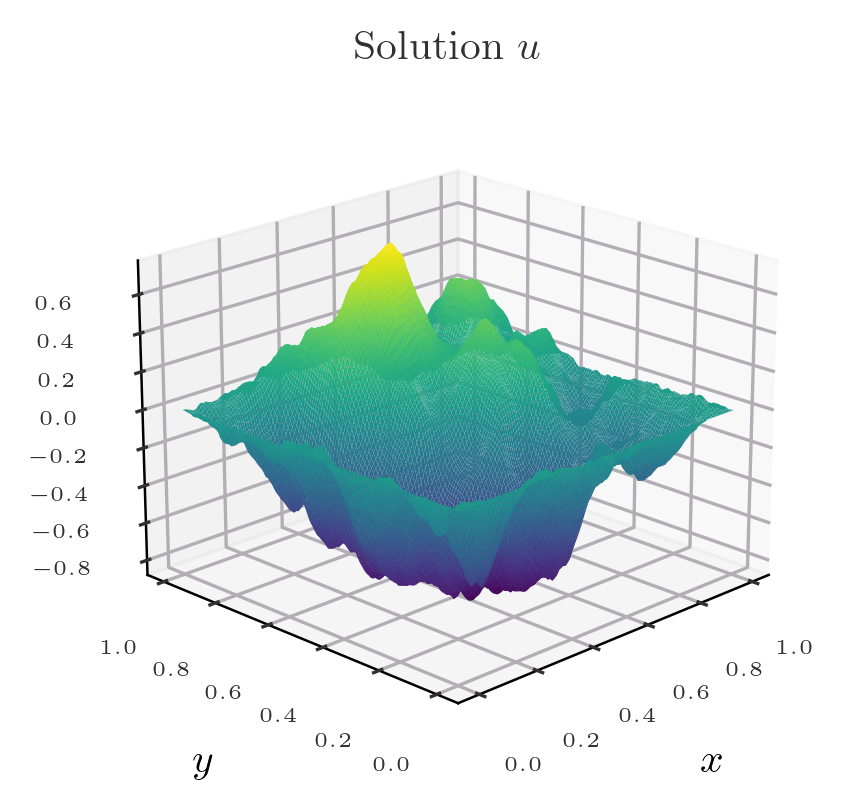

In [12]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

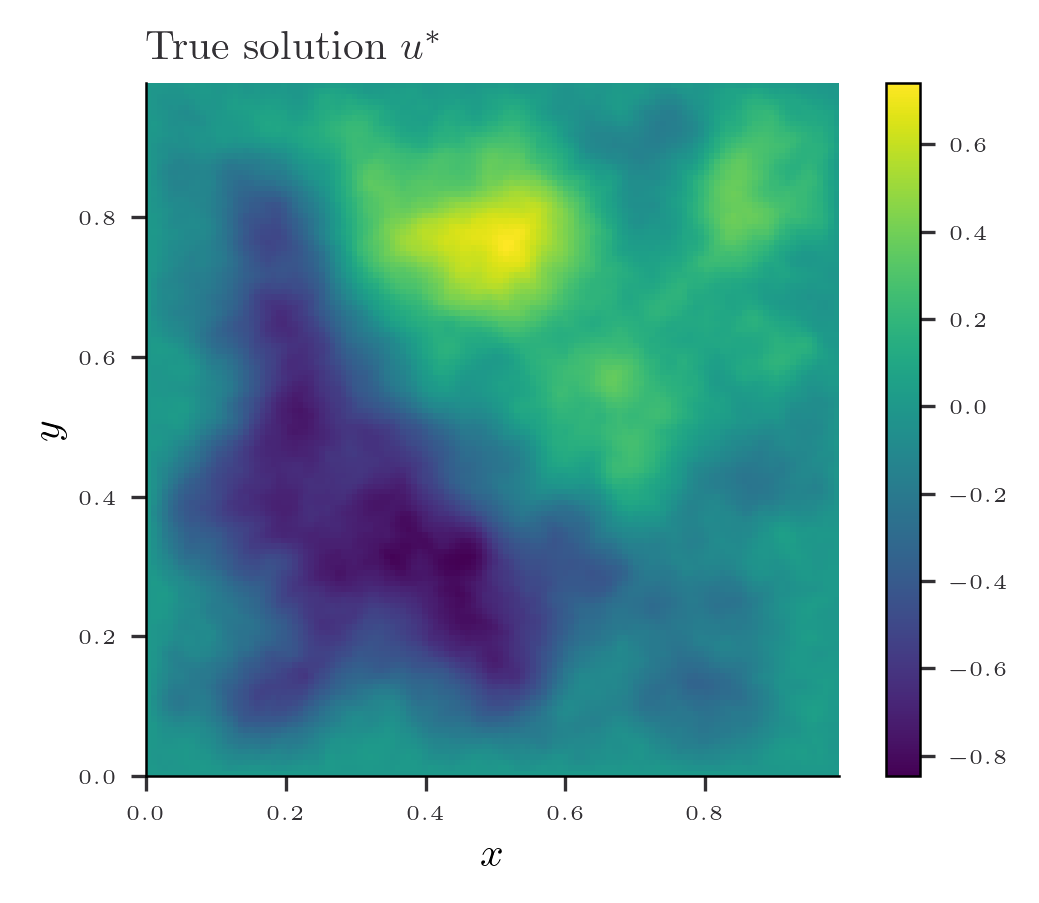

In [13]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

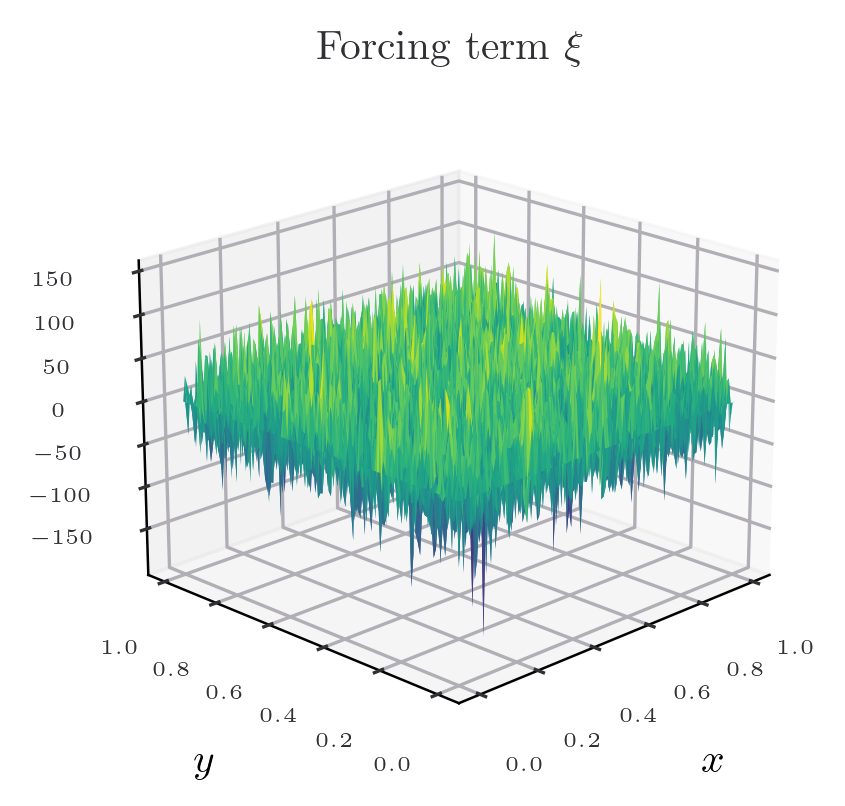

In [14]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, f_values,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Forcing term $\xi$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

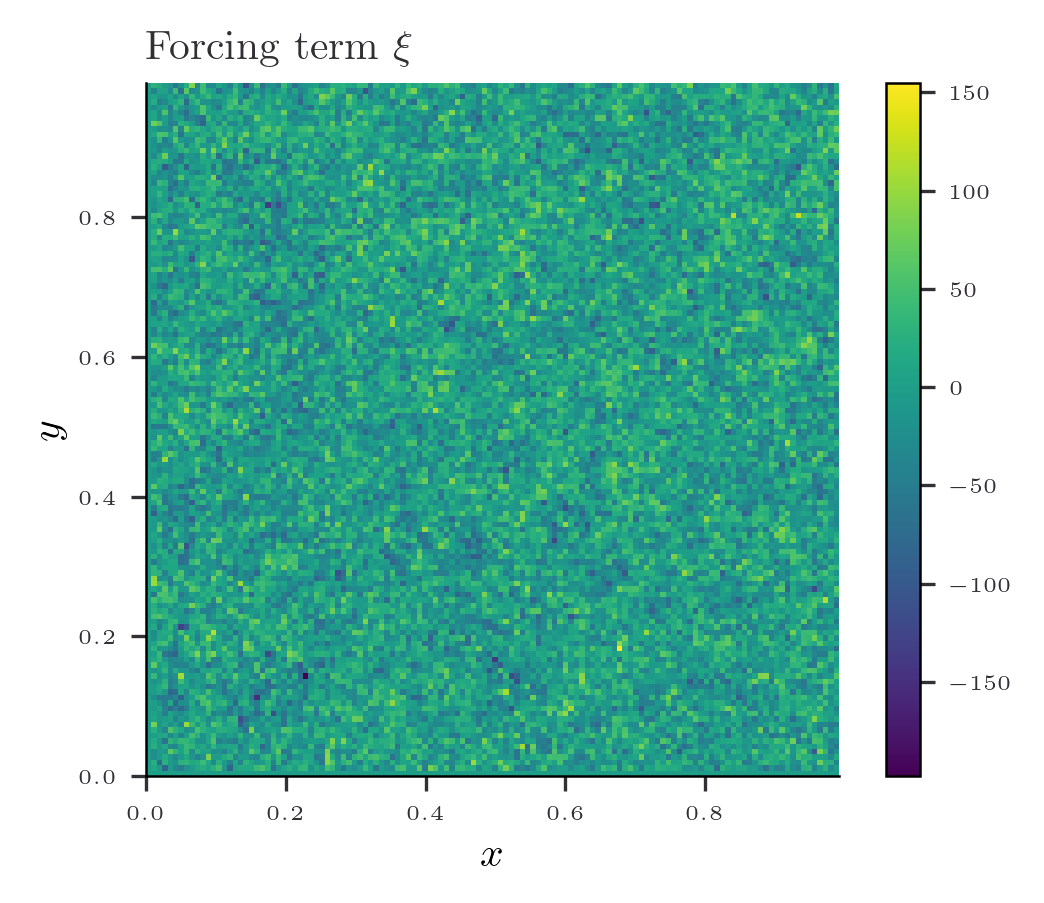

In [15]:
fig = plt.figure(figsize=(width, height))

plt.imshow(f_values[::-1, :], cmap='viridis', extent=[x_finest.min(), x_finest.max(), y_finest.min(), y_finest.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Forcing term $\xi$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

In [16]:
u_trans = dst_2d(u_values)
f_trans = dst_2d(f_values)
print(jnp.mean(jnp.abs(u_trans- coef_u)))

3.6245722661677274e-05


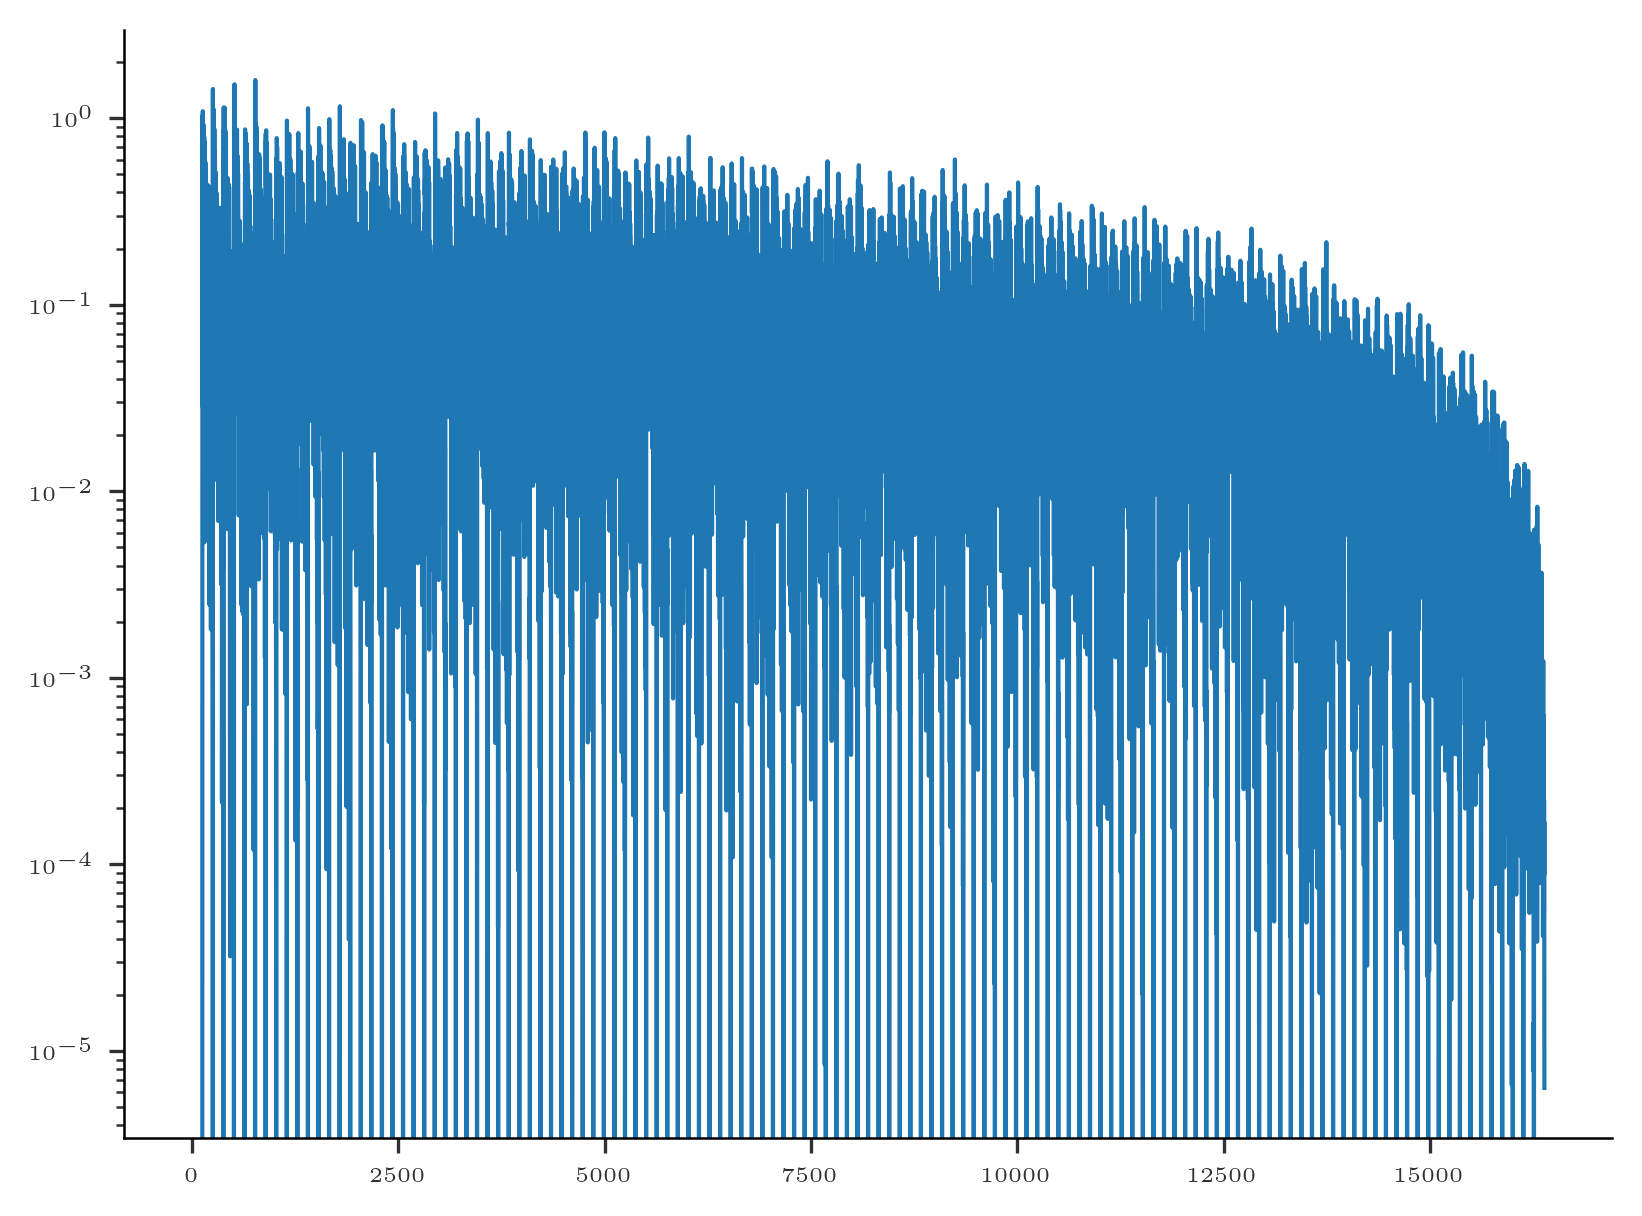

In [17]:
plt.plot(jnp.abs(f_trans.reshape(-1)), label = "f")
plt.yscale("log")
plt.show()

In [18]:
lower = 0.0
upper = 1.0
domain = jnp.array([lower,upper])


# 2d grid 
n_points = 2**6
print("Number of points {} ({} measurements)".format(n_points, n_points**2))
x = jnp.linspace(lower, upper, n_points, endpoint=False)
y = jnp.linspace(lower, upper, n_points, endpoint=False)
X, Y = jnp.meshgrid(x, y)

interior = create_interior(x, y)

Number of points 64 (4096 measurements)


In [19]:
# Create the boundary
n_boundary = 2**7
print("Number of boundary points: {} ({} total)".format(n_boundary, n_boundary*4))

# Create a boundary
# Boundary points
boundary = jnp.linspace(0,1, n_boundary)

boundary_points = []
# Creat a discretization of the boundary
for i in [0,1]:
    boundary_points.append(jnp.stack([jnp.zeros(n_boundary) + i, boundary], axis=-1))
for i in [0,1]:
    boundary_points.append(jnp.stack([boundary, jnp.zeros(n_boundary) + i], axis=-1))
    

boundary_points = jnp.concatenate(boundary_points, axis=0)
boundary_condition = jnp.zeros(shape = boundary_points.shape[0])

Number of boundary points: 128 (512 total)


# RFF embedding

In [290]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [291]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2

sigma_rff = 5.0
random_features = random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff


def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

Number of samples:  32


In [292]:
layer_sizes = [n_samples*2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 8385 parameters in the neural network.


In [293]:
def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [294]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [295]:
# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [296]:
f_observed =  f_trans[:n_points,:n_points]
f_observed

Array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.41736873, -1.02813593, ..., -0.203404  ,
         0.22311882,  0.43977695],
       [-0.        , -1.43503363, -0.02708068, ...,  0.32359806,
         0.26815807,  0.02972378],
       ...,
       [-0.        , -0.14150558,  0.28232389, ...,  0.00510233,
        -0.16417319, -0.22525732],
       [-0.        , -0.14378408,  0.08899411, ...,  0.23014135,
         0.02384538, -0.04441765],
       [-0.        ,  0.13261293,  0.20310402, ..., -0.14327253,
         0.16327559, -0.09289254]], dtype=float64)

In [297]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.8494091326982767 [(Array([[ 0.00757545,  0.02158182, -0.00942444, ...,  0.00195096,
         0.05515687, -0.00500754],
       [ 0.01385922,  0.02108681, -0.02449601, ...,  0.00434395,
         0.06497911, -0.0013676 ],
       [-0.0266321 , -0.00938288,  0.05926735, ..., -0.03307228,
        -0.10252941,  0.00566118],
       ...,
       [ 0.02679688,  0.01121879, -0.05067973, ...,  0.01941365,
         0.09984659, -0.00470053],
       [-0.01508463, -0.02032429,  0.0163836 , ...,  0.0028561 ,
        -0.07230469, -0.00243402],
       [-0.00406364,  0.00040279,  0.0169663 , ..., -0.02595476,
         0.00540828, -0.00373119]], dtype=float64), Array([-0.01761897, -0.00842325,  0.04942201,  0.10993946,  0.1801667 ,
        0.05511654, -0.13888007,  0.0298598 , -0.01922194, -0.14434542,
        0.00626765, -0.00835749,  0.05931084,  0.03639741,  0.02403941,
        0.07193333,  0.09567308,  0.10581237, -0.15679171, -0.00294875,
       -0.02133736, -0.05017644, -0.02120053, -0.03383774, -0.

In [298]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [299]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [300]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [301]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.8494091
Step 0, Training Loss: 0.8494091, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0000444
Step 10000, Training Loss: 0.0000444, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0000663
Step 20000, Training Loss: 0.0000663, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0000269
Step 30000, Training Loss: 0.0000269, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0000276
Step 40000, Training Loss: 0.0000276, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000205
Step 50000, Training Loss: 0.0000205, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000181
Step 60000, Training Loss: 0.0000181, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000171
Step 70000, Training Loss: 0.0000171, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000153
Step 80000, Training Loss: 0.0000153, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000142
Step 90000, Training Loss: 0.0000142, Learning Rate: 0.000387


In [302]:
loss

Array(1.33611692e-05, dtype=float64)

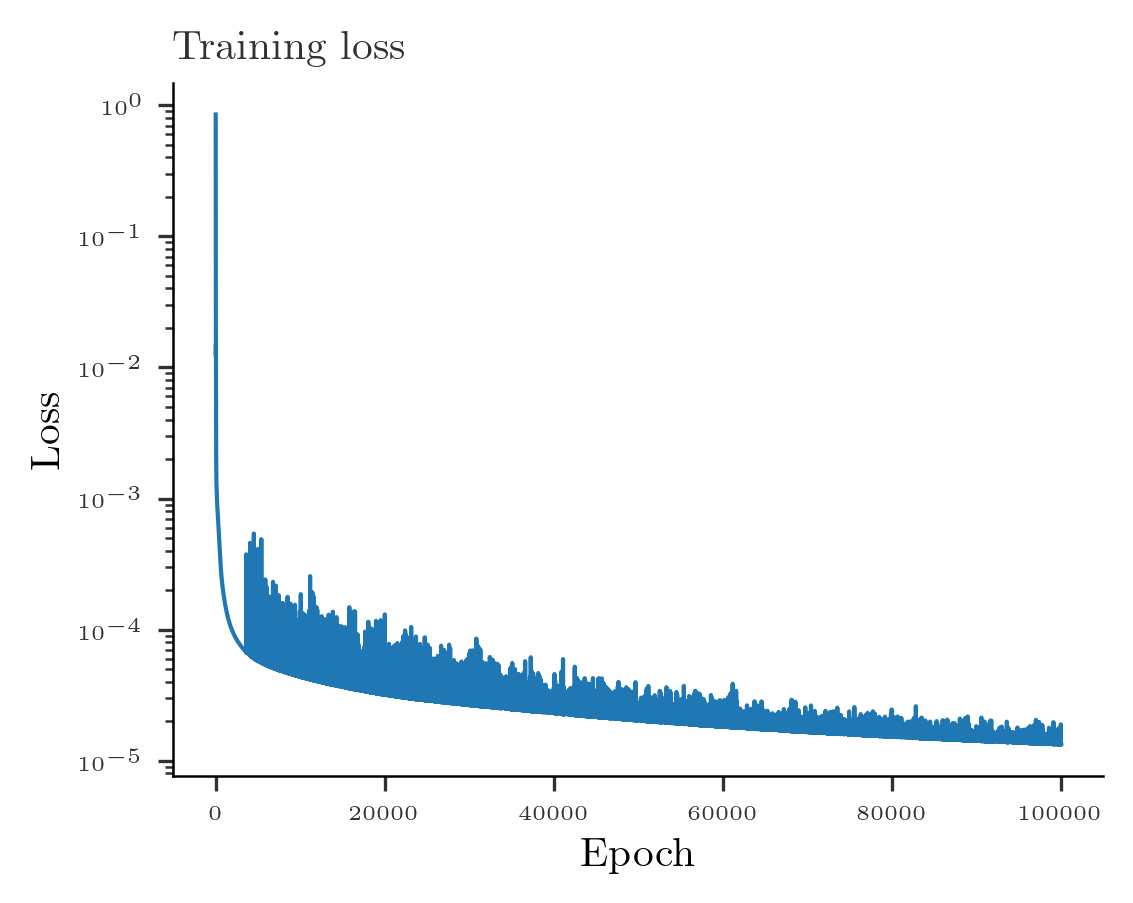

In [303]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [304]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [305]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [306]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01747119, dtype=float64), Array(0.05378772, dtype=float64))


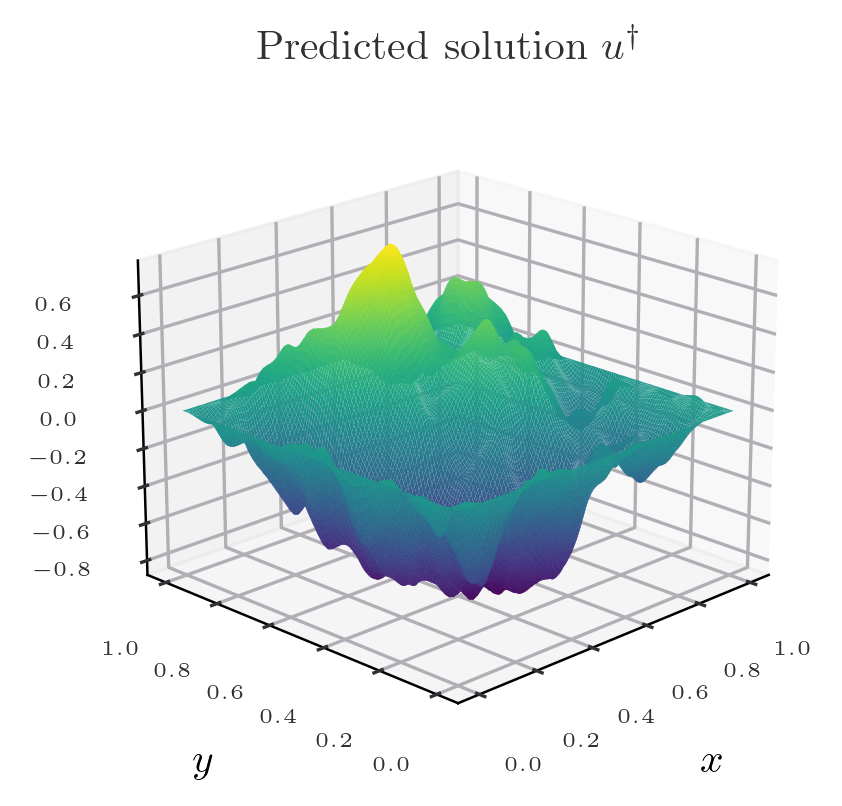

In [307]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

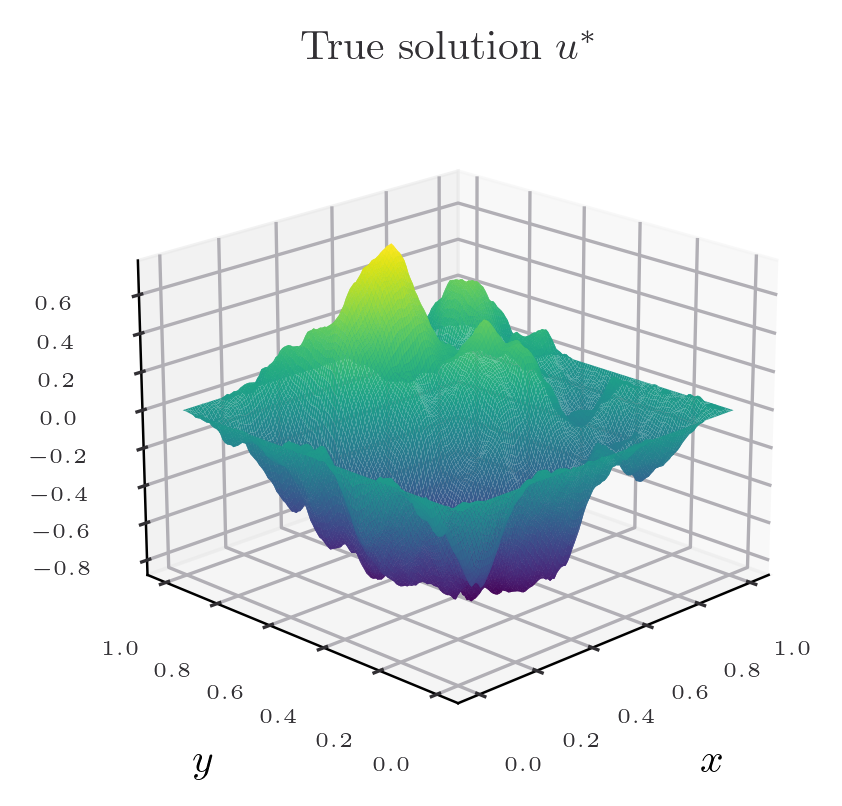

In [308]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

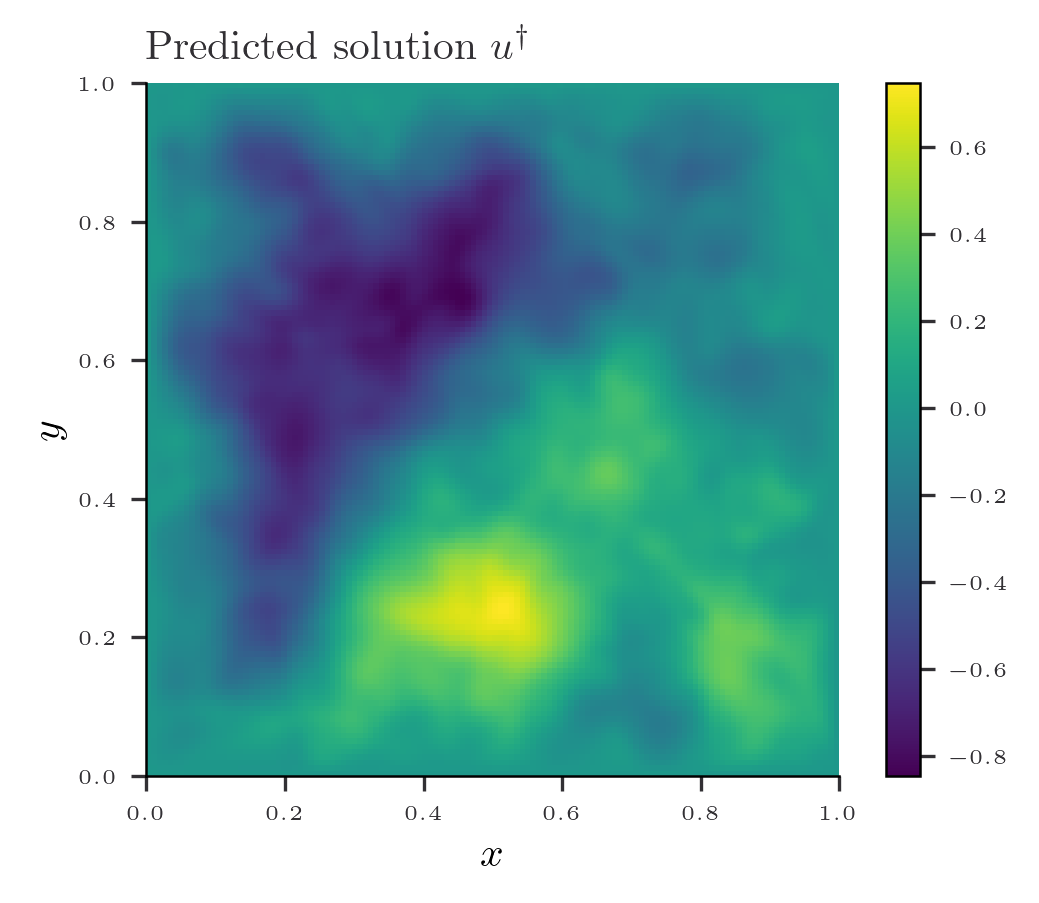

In [309]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

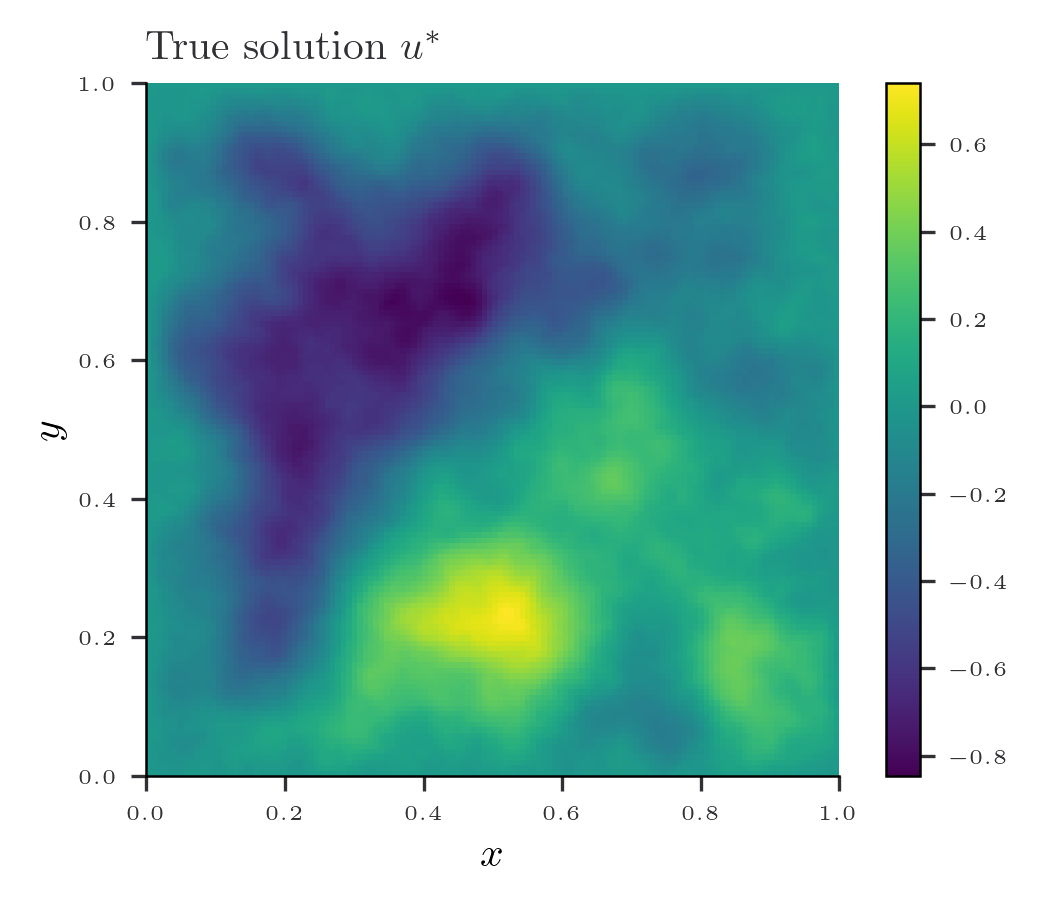

In [310]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

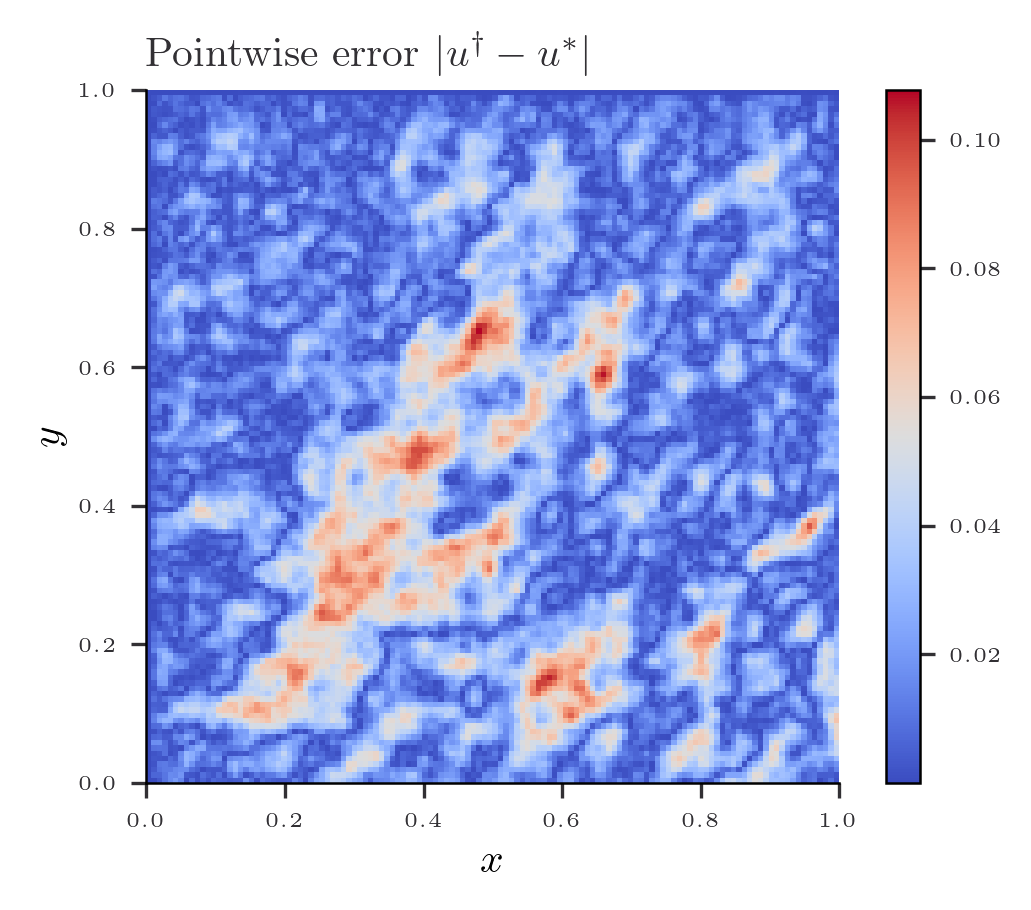

In [311]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# RFF embedding overparametrized

In [43]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [44]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2

sigma_rff = 5.0
random_features = random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff


def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

Number of samples:  32


In [45]:
layer_sizes = [n_samples*2, 64, 64, 64, 1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 12545 parameters in the neural network.


In [46]:
def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [47]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [48]:
# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [49]:
f_observed =  f_trans[:n_points,:n_points]
f_observed

Array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.41736873, -1.02813593, ..., -0.203404  ,
         0.22311882,  0.43977695],
       [-0.        , -1.43503363, -0.02708068, ...,  0.32359806,
         0.26815807,  0.02972378],
       ...,
       [-0.        , -0.14150558,  0.28232389, ...,  0.00510233,
        -0.16417319, -0.22525732],
       [-0.        , -0.14378408,  0.08899411, ...,  0.23014135,
         0.02384538, -0.04441765],
       [-0.        ,  0.13261293,  0.20310402, ..., -0.14327253,
         0.16327559, -0.09289254]], dtype=float64)

In [50]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.2874854301952721 [(Array([[ 0.01784077,  0.02869437,  0.01897492, ..., -0.02816715,
        -0.02920476, -0.00787876],
       [ 0.02312887,  0.03687762,  0.04238683, ..., -0.03155463,
        -0.0263312 , -0.00749355],
       [ 0.00534099,  0.03609358,  0.02917574, ..., -0.01812776,
         0.0028276 ,  0.00397949],
       ...,
       [ 0.01180566,  0.01806999,  0.03666599, ..., -0.02079716,
        -0.00469108, -0.00390378],
       [-0.01010876, -0.01123813, -0.00515405, ...,  0.01160551,
         0.00727995, -0.00317058],
       [ 0.00863013,  0.02125162,  0.0057271 , ..., -0.006941  ,
        -0.00252577,  0.0046492 ]], dtype=float64), Array([-1.47138398e-02,  2.28777985e-02, -2.28970313e-02, -4.22892787e-02,
       -9.37113055e-04, -9.66156926e-04, -2.85701175e-02,  3.21867113e-02,
       -6.51556956e-03, -3.11440895e-03,  5.14520336e-03, -9.68429298e-03,
        6.96166209e-05, -1.82790705e-02, -2.46124088e-02,  2.74841186e-02,
        1.08003666e-03,  3.39222219e-03, -1.822331

In [51]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [52]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [53]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [54]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.2874854
Step 0, Training Loss: 0.2874854, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0000881
Step 10000, Training Loss: 0.0000881, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0000213
Step 20000, Training Loss: 0.0000213, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0000167
Step 30000, Training Loss: 0.0000167, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0000138
Step 40000, Training Loss: 0.0000138, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000123
Step 50000, Training Loss: 0.0000123, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000096
Step 60000, Training Loss: 0.0000096, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000082
Step 70000, Training Loss: 0.0000082, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000074
Step 80000, Training Loss: 0.0000074, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000065
Step 90000, Training Loss: 0.0000065, Learning Rate: 0.000387


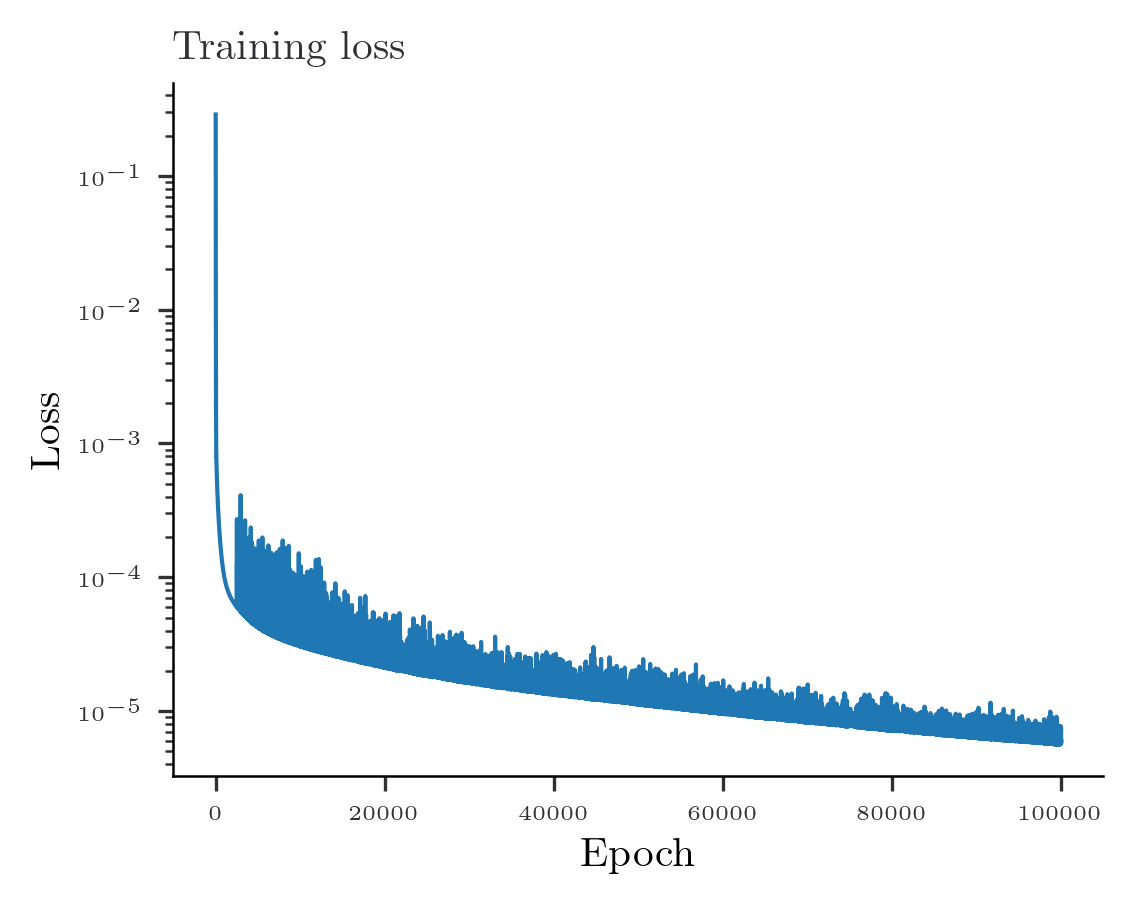

In [55]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [56]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [57]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [58]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.01858556, dtype=float64), Array(0.0572185, dtype=float64))


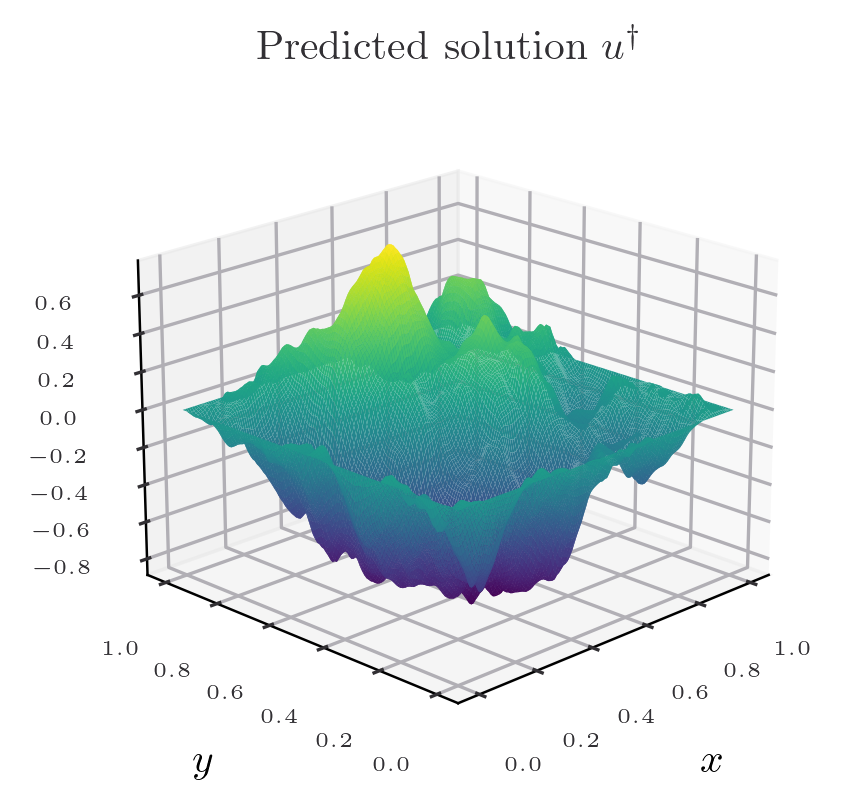

In [59]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

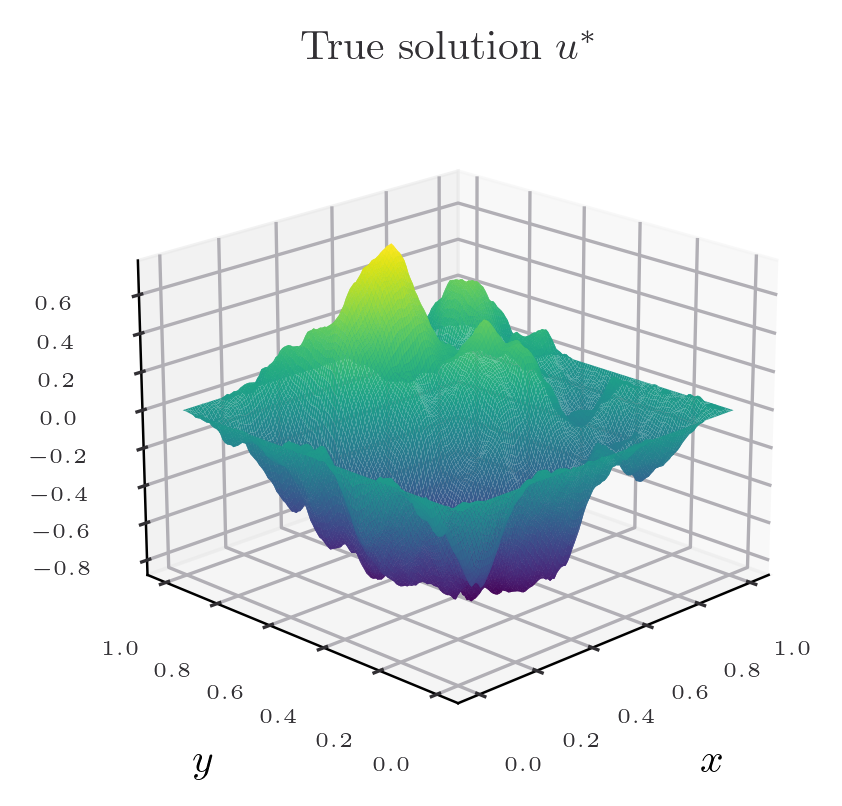

In [60]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

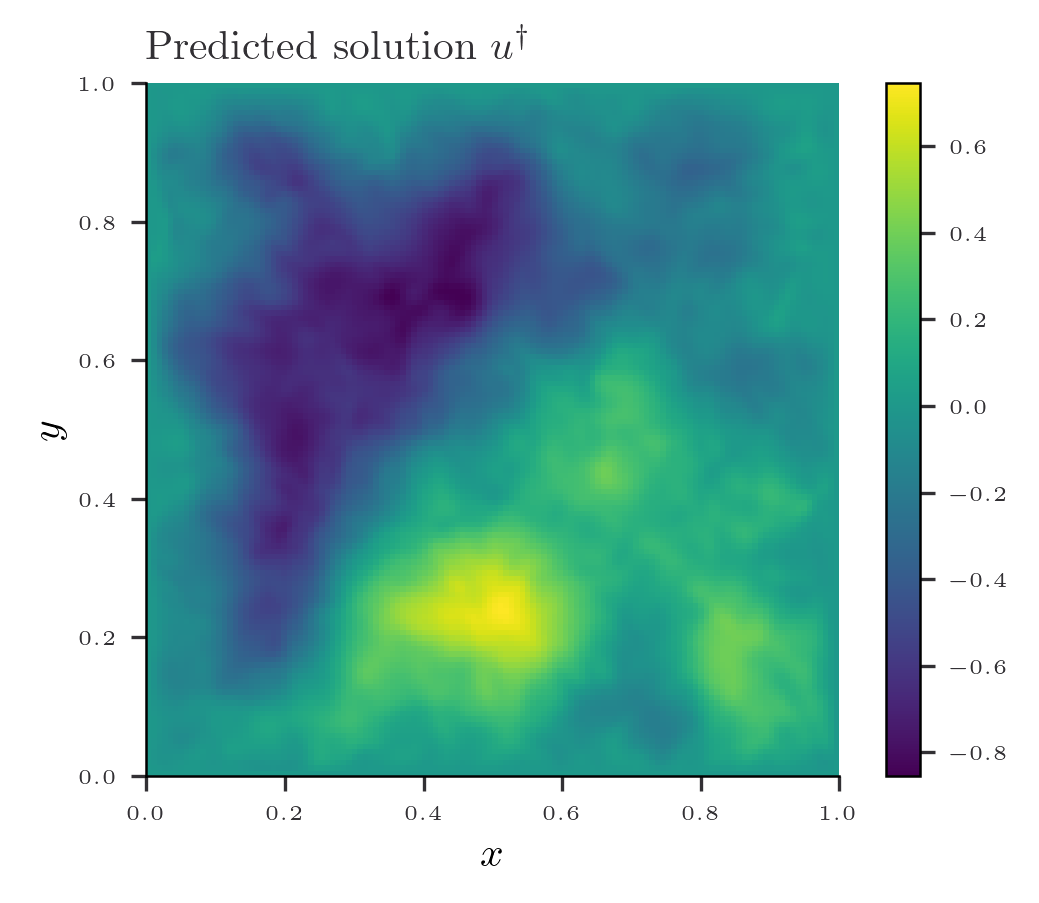

In [61]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

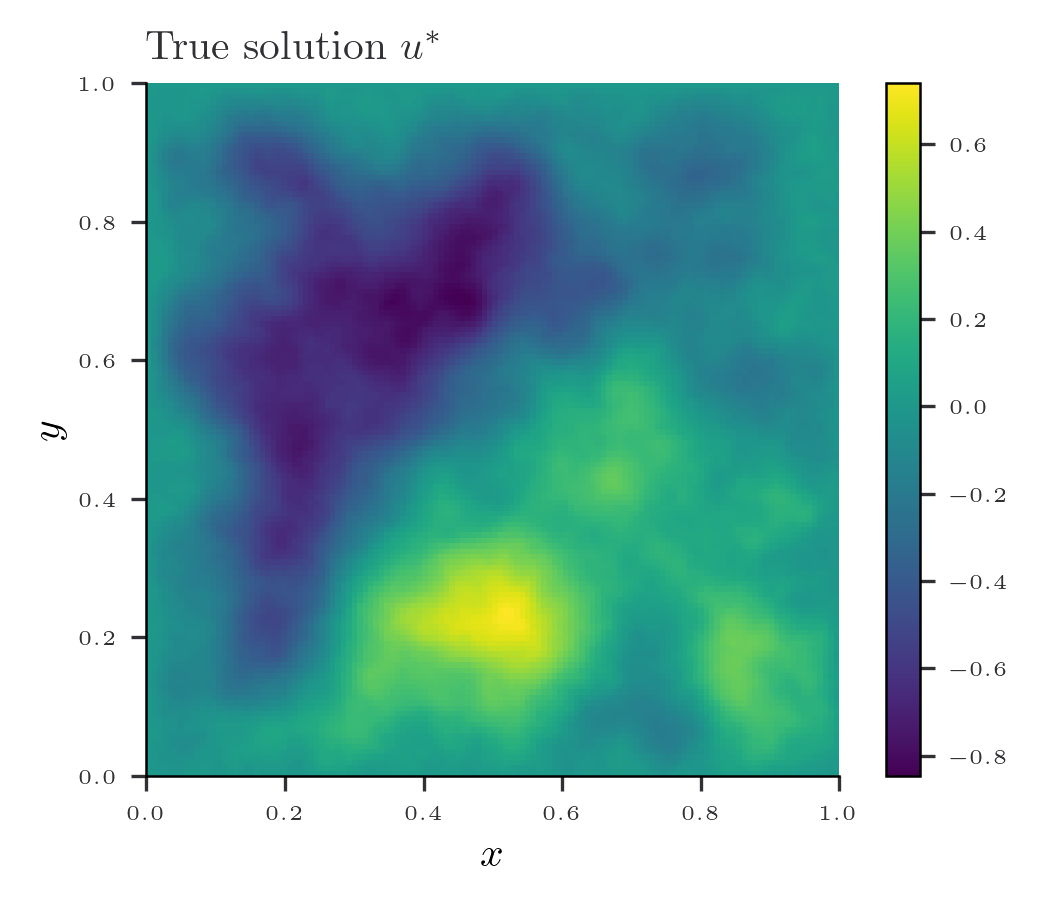

In [62]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

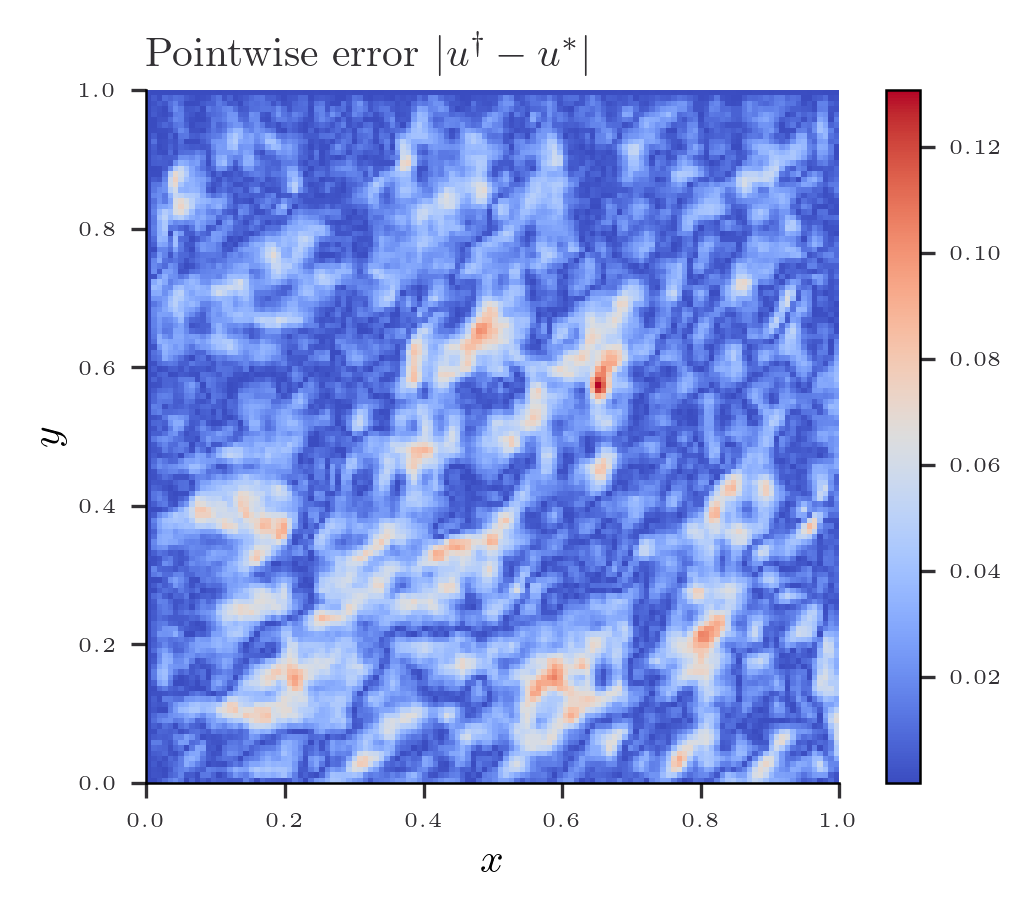

In [63]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# RFF embedding small

In [414]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [415]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2

sigma_rff = 5.0
random_features = random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff


def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

Number of samples:  32


In [416]:
layer_sizes = [n_samples*2, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 3169 parameters in the neural network.


In [417]:
def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [418]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [419]:
# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [420]:
f_observed =  f_trans[:n_points,:n_points]
f_observed

Array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.41736873, -1.02813593, ..., -0.203404  ,
         0.22311882,  0.43977695],
       [-0.        , -1.43503363, -0.02708068, ...,  0.32359806,
         0.26815807,  0.02972378],
       ...,
       [-0.        , -0.14150558,  0.28232389, ...,  0.00510233,
        -0.16417319, -0.22525732],
       [-0.        , -0.14378408,  0.08899411, ...,  0.23014135,
         0.02384538, -0.04441765],
       [-0.        ,  0.13261293,  0.20310402, ..., -0.14327253,
         0.16327559, -0.09289254]], dtype=float64)

In [421]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

1.953361206830082 [(Array([[ 0.01907516, -0.05829454, -0.0543566 , ..., -0.11138599,
        -0.02012286,  0.23319958],
       [ 0.1022031 , -0.19509799, -0.16017178, ..., -0.1548244 ,
        -0.01584933,  0.27643074],
       [ 0.09061508, -0.12142517, -0.07504021, ..., -0.06490905,
        -0.00714855,  0.03500504],
       ...,
       [-0.02505679,  0.08004317,  0.06965015, ...,  0.0728125 ,
        -0.02364567, -0.08107647],
       [-0.03991169,  0.13422283,  0.03240614, ...,  0.10001224,
        -0.05212363, -0.10446573],
       [ 0.00748199, -0.05625241, -0.02103416, ..., -0.08804962,
         0.05106451,  0.03450491]], dtype=float64), Array([-0.10271507,  0.0587459 ,  0.07815297, -0.10594002,  0.02297366,
       -0.08024012, -0.0949914 ,  0.05423137,  0.13025505, -0.03299646,
        0.00695152, -0.03852286, -0.06650745,  0.11975179,  0.03514613,
       -0.0284319 , -0.11953204,  0.23266579, -0.03189205, -0.08639398,
        0.27220334,  0.10750832, -0.17497073,  0.03949189, -0.0

In [ ]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [ ]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [ ]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [ ]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1.0454013
Step 0, Training Loss: 1.0454013, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0000481
Step 10000, Training Loss: 0.0000481, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0000363
Step 20000, Training Loss: 0.0000363, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0000315
Step 30000, Training Loss: 0.0000315, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0000297
Step 40000, Training Loss: 0.0000297, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000376
Step 50000, Training Loss: 0.0000376, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000246
Step 60000, Training Loss: 0.0000246, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000232
Step 70000, Training Loss: 0.0000232, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000221
Step 80000, Training Loss: 0.0000221, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000212
Step 90000, Training Loss: 0.0000212, Learning Rate: 0.000387


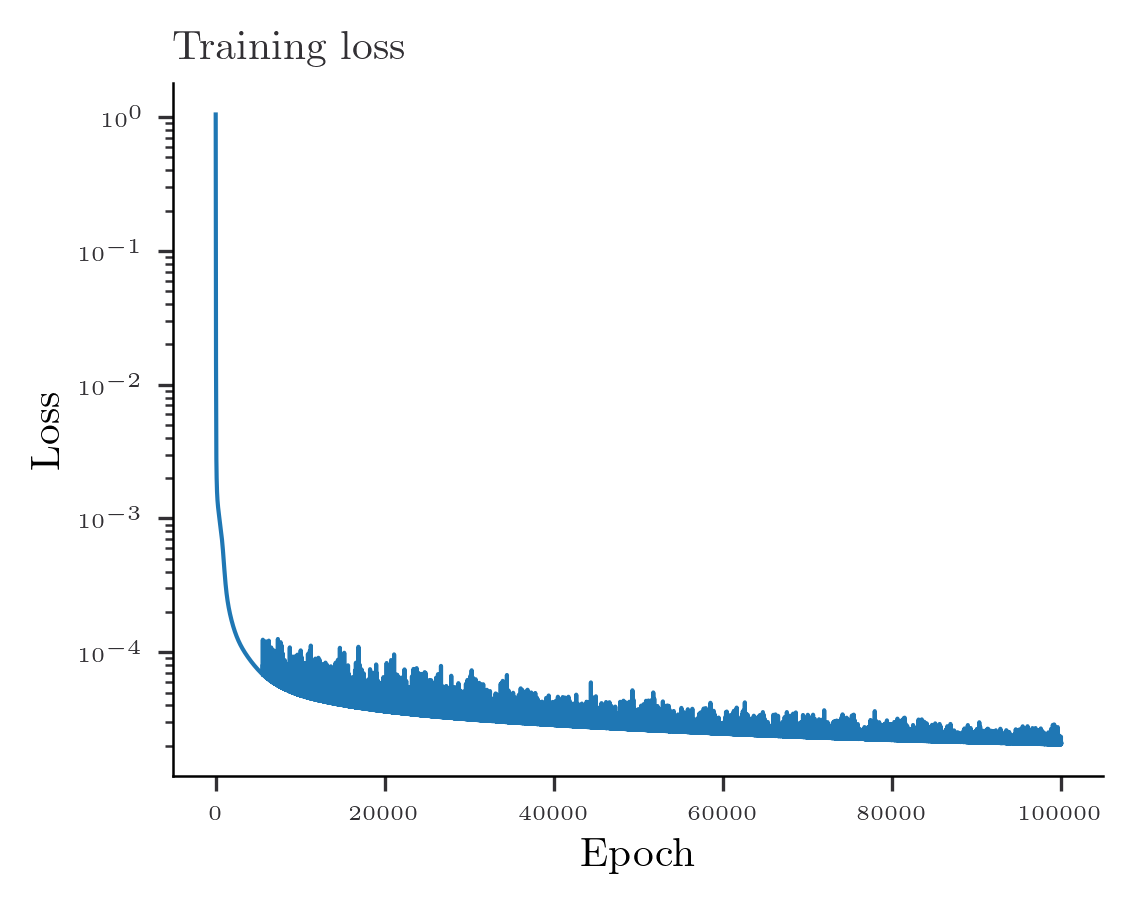

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [ ]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [ ]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [ ]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.0176469, dtype=float64), Array(0.05432869, dtype=float64))


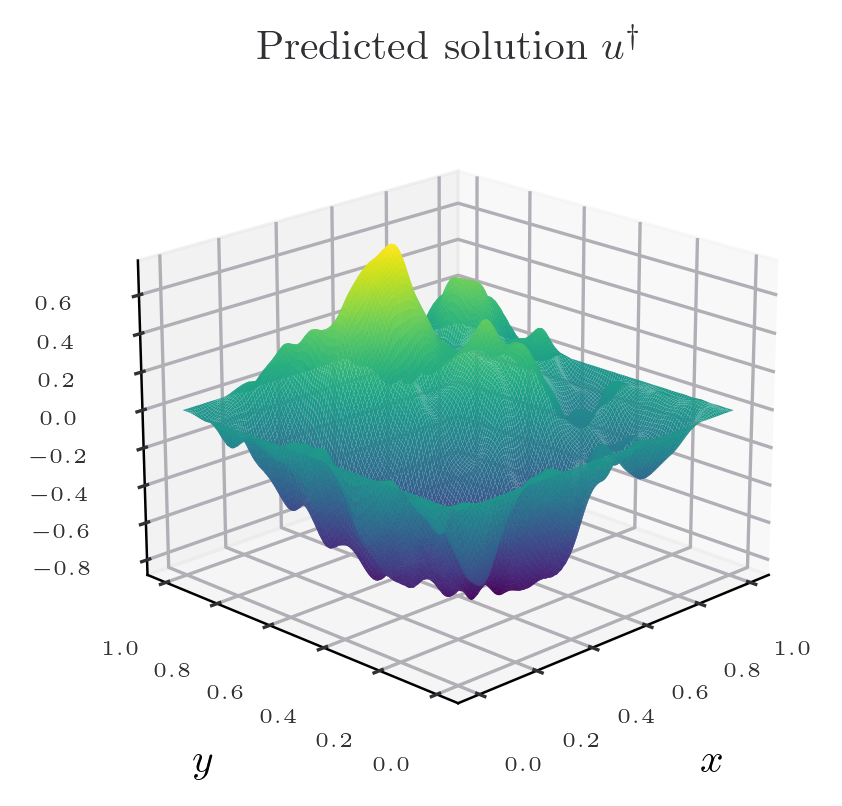

In [ ]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

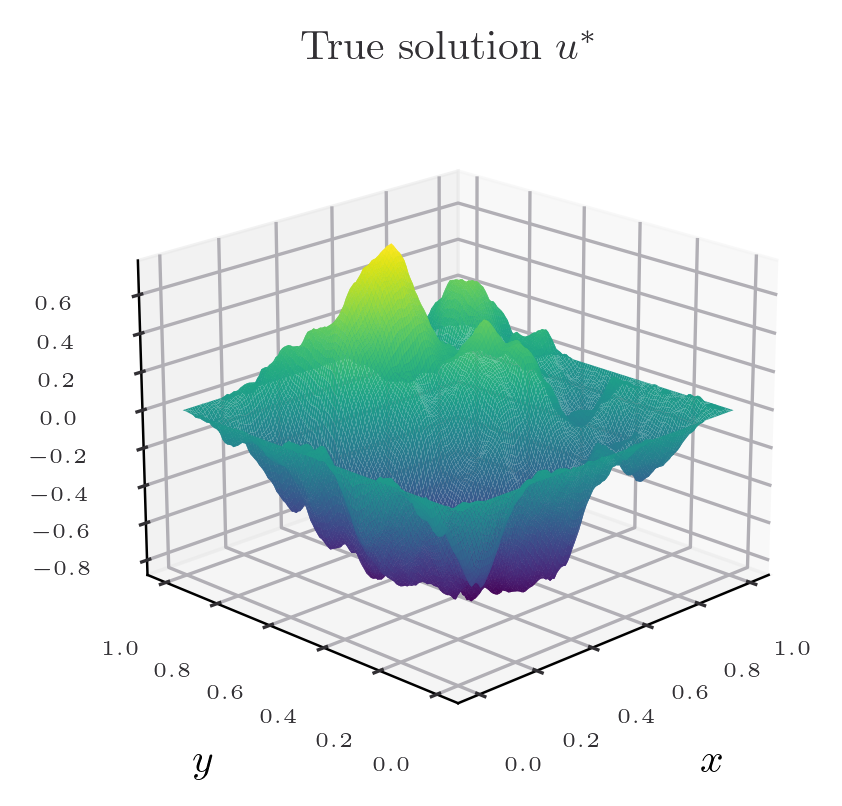

In [ ]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

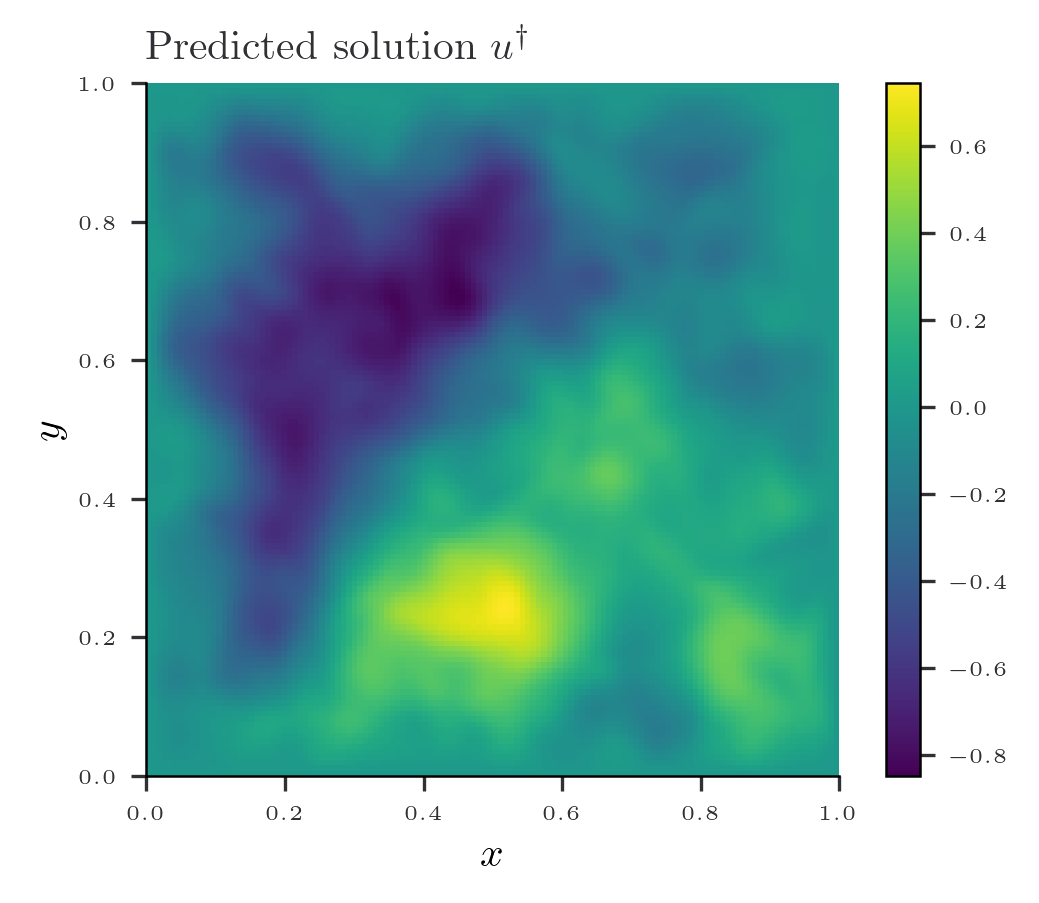

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

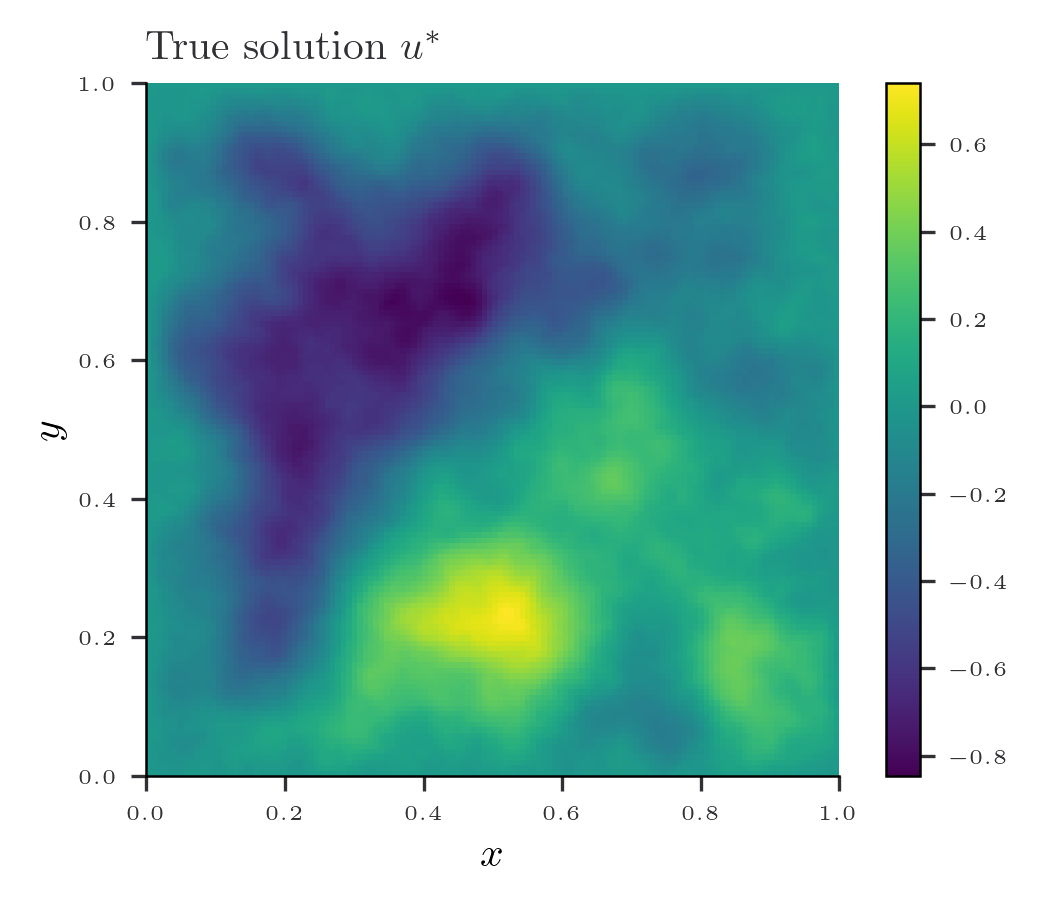

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

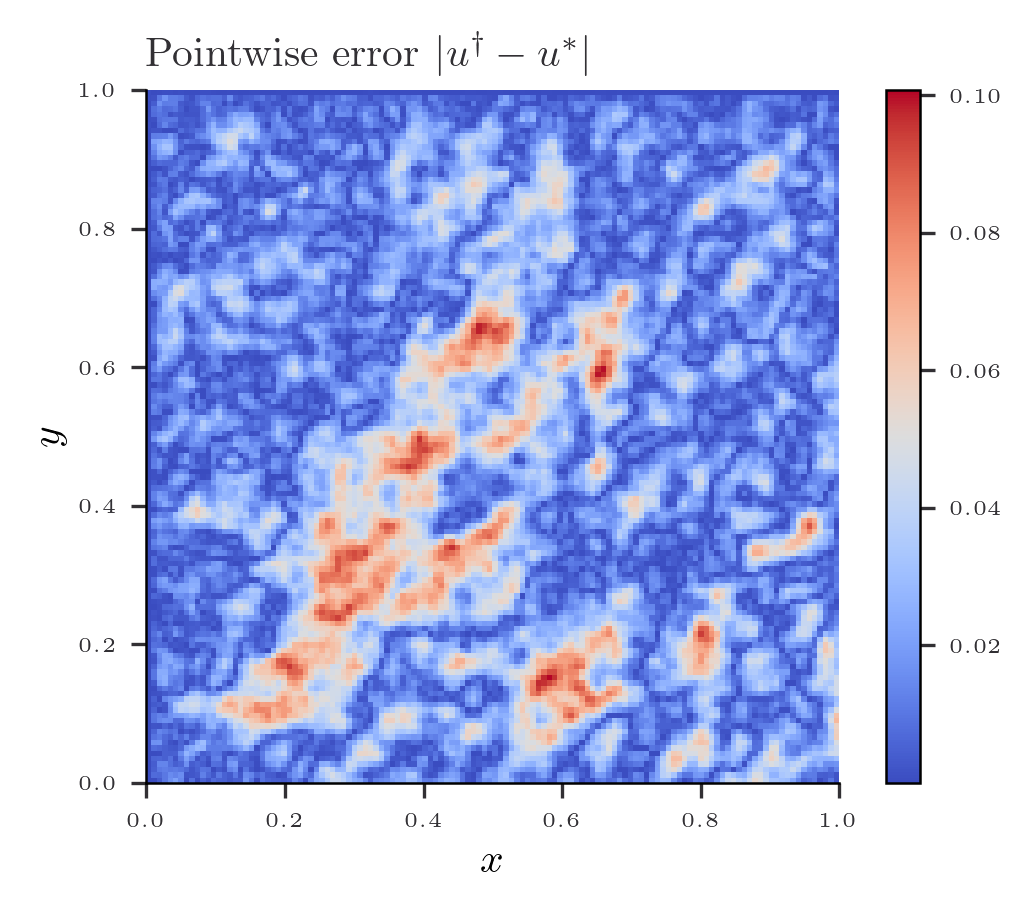

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# RFF embedding large + long training time + weight decay

In [316]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [317]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2

sigma_rff = 5.0
random_features = random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff


def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

Number of samples:  32


In [318]:
layer_sizes = [n_samples*2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 8385 parameters in the neural network.


In [319]:
def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [320]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [322]:


# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [323]:
f_observed =  f_trans[:n_points,:n_points]
f_observed

Array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.41736873, -1.02813593, ..., -0.203404  ,
         0.22311882,  0.43977695],
       [-0.        , -1.43503363, -0.02708068, ...,  0.32359806,
         0.26815807,  0.02972378],
       ...,
       [-0.        , -0.14150558,  0.28232389, ...,  0.00510233,
        -0.16417319, -0.22525732],
       [-0.        , -0.14378408,  0.08899411, ...,  0.23014135,
         0.02384538, -0.04441765],
       [-0.        ,  0.13261293,  0.20310402, ..., -0.14327253,
         0.16327559, -0.09289254]], dtype=float64)

In [324]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.8494091326982767 [(Array([[ 0.00757545,  0.02158182, -0.00942444, ...,  0.00195096,
         0.05515687, -0.00500754],
       [ 0.01385922,  0.02108681, -0.02449601, ...,  0.00434395,
         0.06497911, -0.0013676 ],
       [-0.0266321 , -0.00938288,  0.05926735, ..., -0.03307228,
        -0.10252941,  0.00566118],
       ...,
       [ 0.02679688,  0.01121879, -0.05067973, ...,  0.01941365,
         0.09984659, -0.00470053],
       [-0.01508463, -0.02032429,  0.0163836 , ...,  0.0028561 ,
        -0.07230469, -0.00243402],
       [-0.00406364,  0.00040279,  0.0169663 , ..., -0.02595476,
         0.00540828, -0.00373119]], dtype=float64), Array([-0.01761897, -0.00842325,  0.04942201,  0.10993946,  0.1801667 ,
        0.05511654, -0.13888007,  0.0298598 , -0.01922194, -0.14434542,
        0.00626765, -0.00835749,  0.05931084,  0.03639741,  0.02403941,
        0.07193333,  0.09567308,  0.10581237, -0.15679171, -0.00294875,
       -0.02133736, -0.05017644, -0.02120053, -0.03383774, -0.

In [325]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 3e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adamw(learning_rate_schedule, weight_decay = 1e-5)
opt_state = optimizer.init(params)

In [326]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [327]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [328]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.8494091
Step 0, Training Loss: 0.8494091, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0000781
Epoch 20000, Loss: 0.0000314
Epoch 30000, Loss: 0.0000259
Step 30000, Training Loss: 0.0000259, Learning Rate: 0.000900
Epoch 40000, Loss: 0.0000256
Epoch 50000, Loss: 0.0000211
Epoch 60000, Loss: 0.0000168
Step 60000, Training Loss: 0.0000168, Learning Rate: 0.000810
Epoch 70000, Loss: 0.0000180
Epoch 80000, Loss: 0.0000160
Epoch 90000, Loss: 0.0000165
Step 90000, Training Loss: 0.0000165, Learning Rate: 0.000729
Epoch 100000, Loss: 0.0000171
Epoch 110000, Loss: 0.0000110
Epoch 120000, Loss: 0.0000146
Step 120000, Training Loss: 0.0000146, Learning Rate: 0.000656
Epoch 130000, Loss: 0.0000124
Epoch 140000, Loss: 0.0000092
Epoch 150000, Loss: 0.0000109
Step 150000, Training Loss: 0.0000109, Learning Rate: 0.000590
Epoch 160000, Loss: 0.0000097
Epoch 170000, Loss: 0.0000136
Epoch 180000, Loss: 0.0000087
Step 180000, Training Loss: 0.0000087, Learning Rate: 0.000531
Epoch 19000

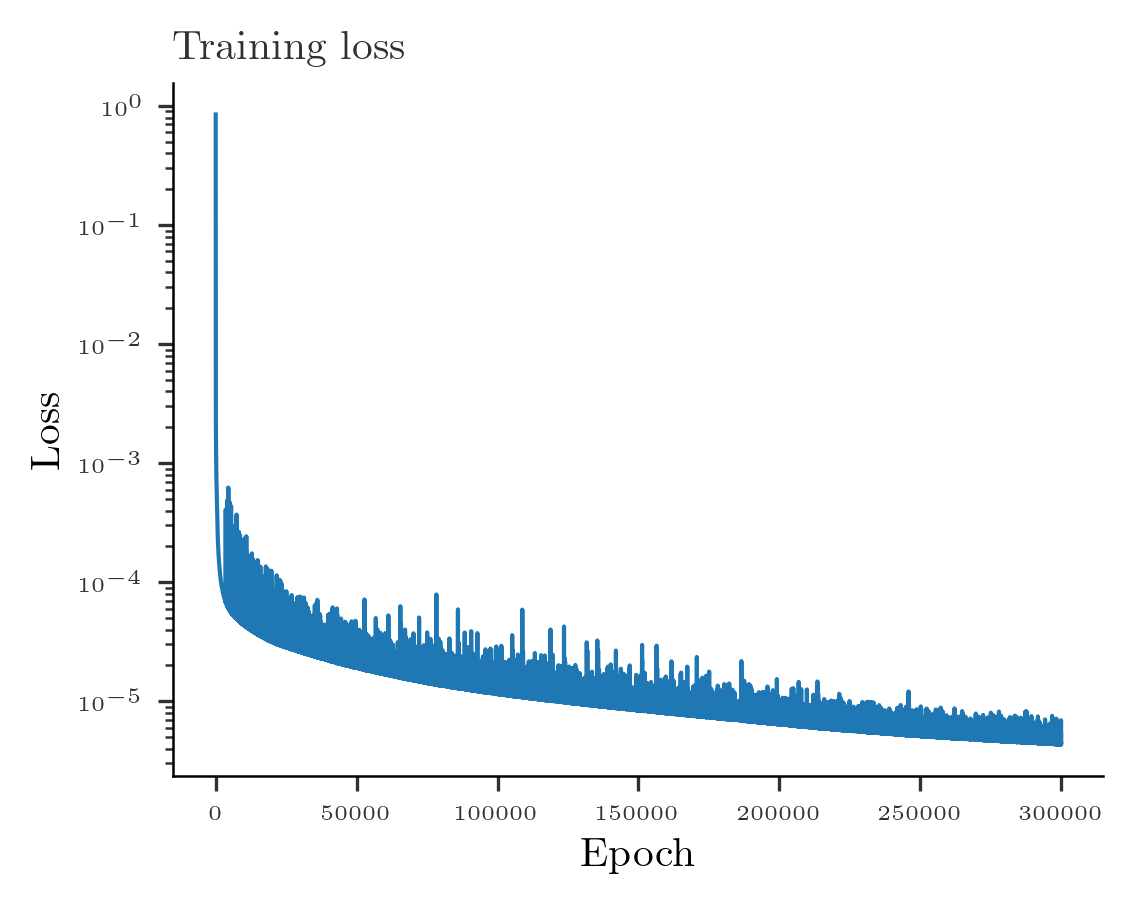

In [329]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [330]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [331]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [332]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.02792322, dtype=float64), Array(0.08596589, dtype=float64))


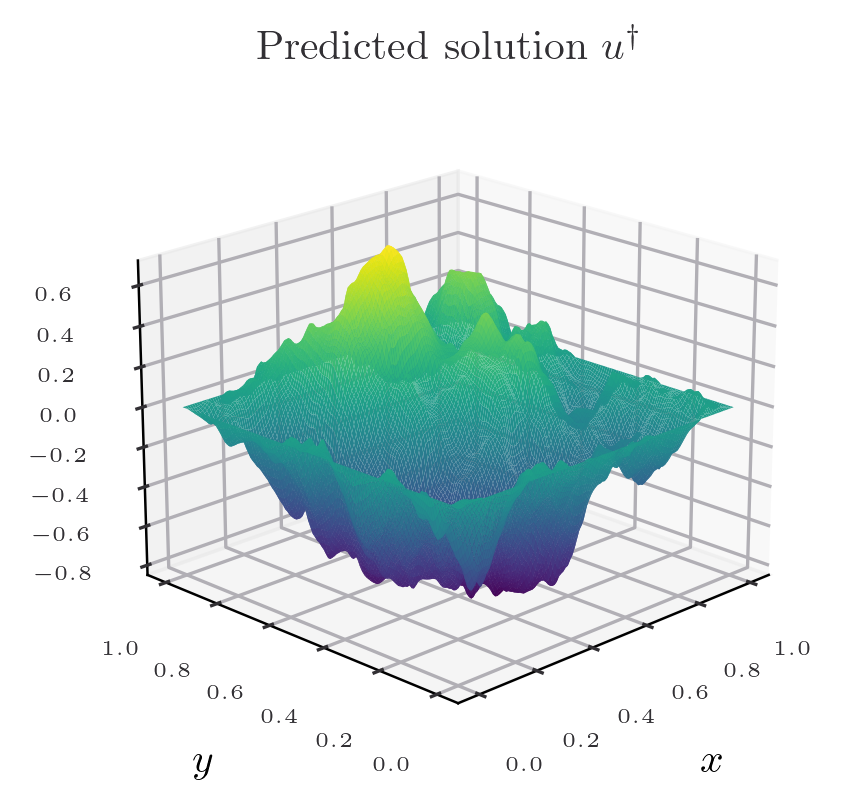

In [333]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

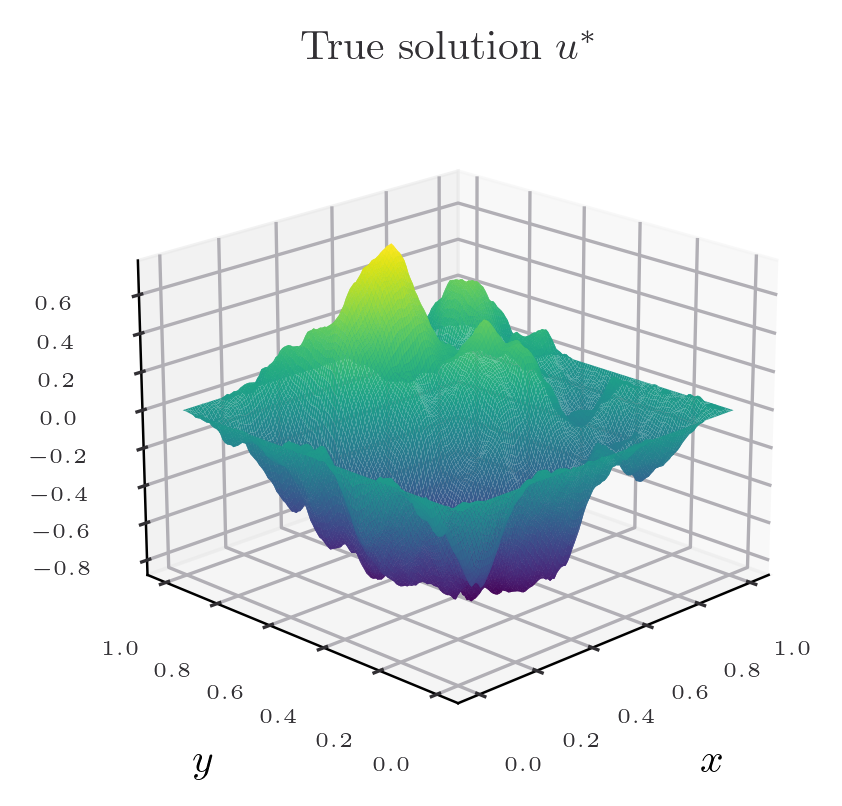

In [334]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

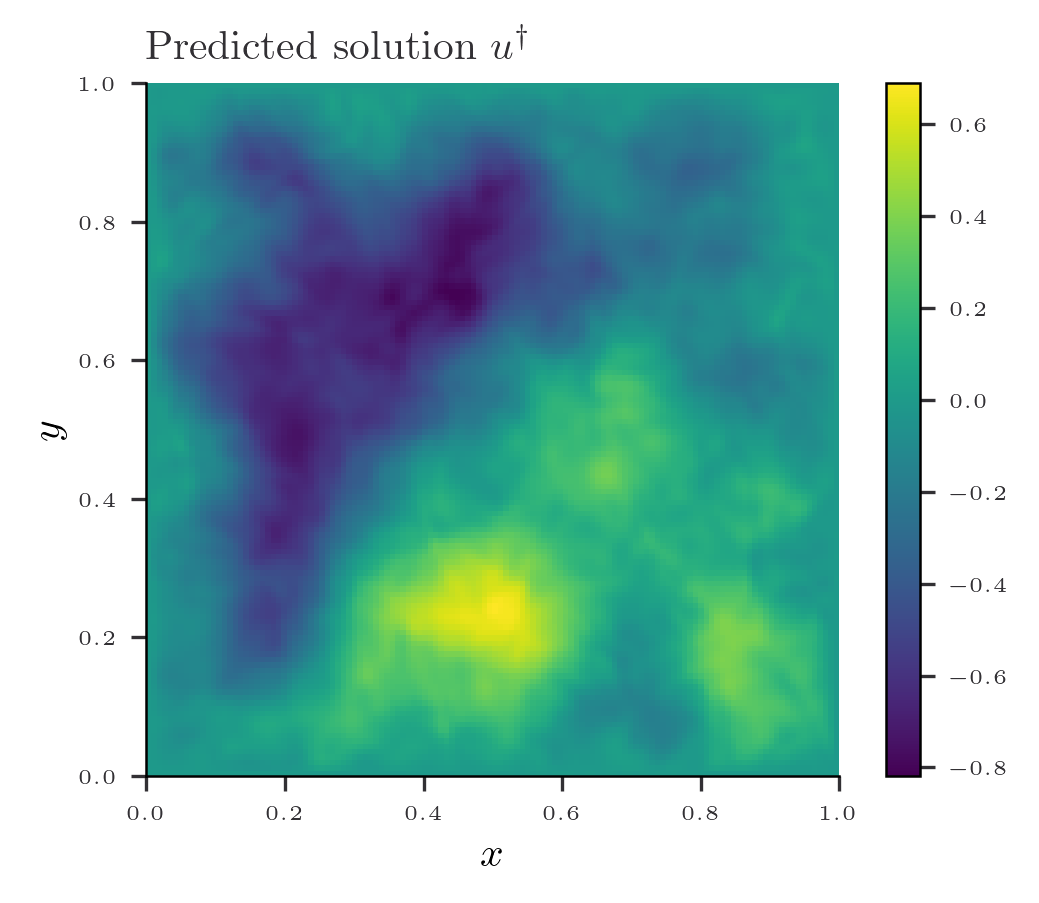

In [335]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

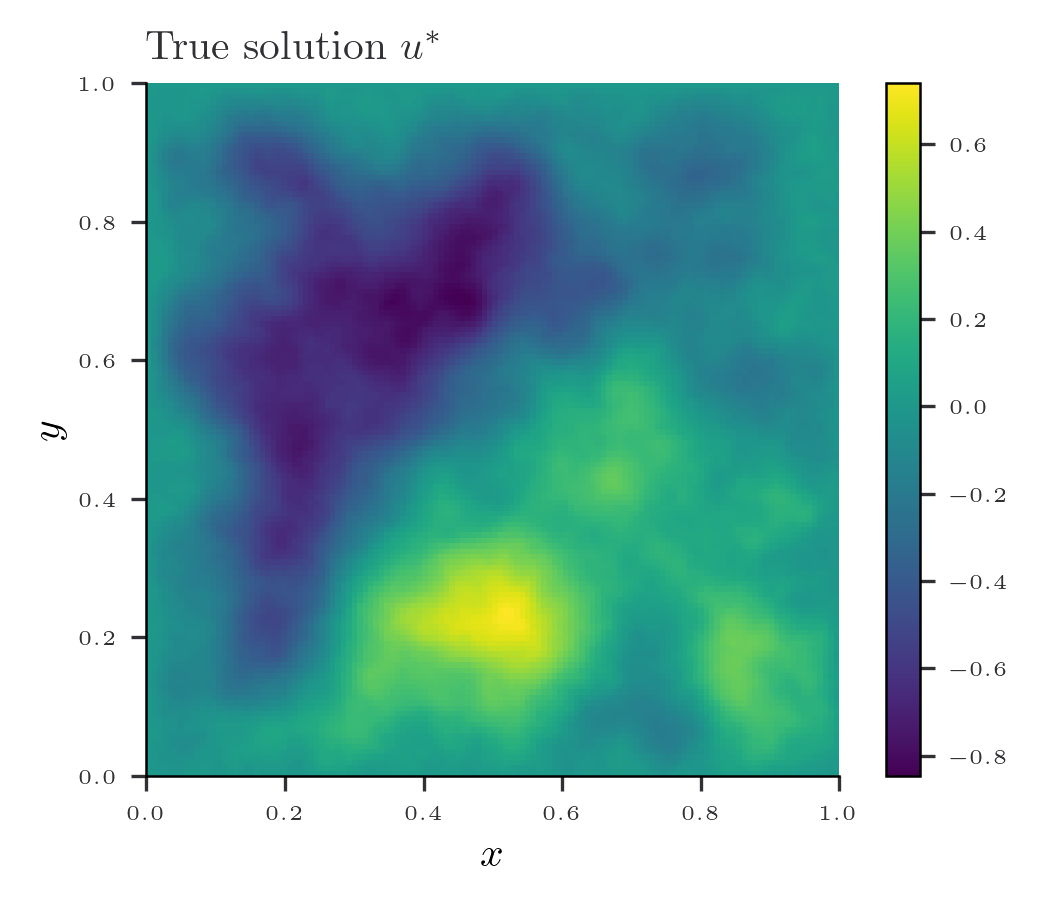

In [336]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

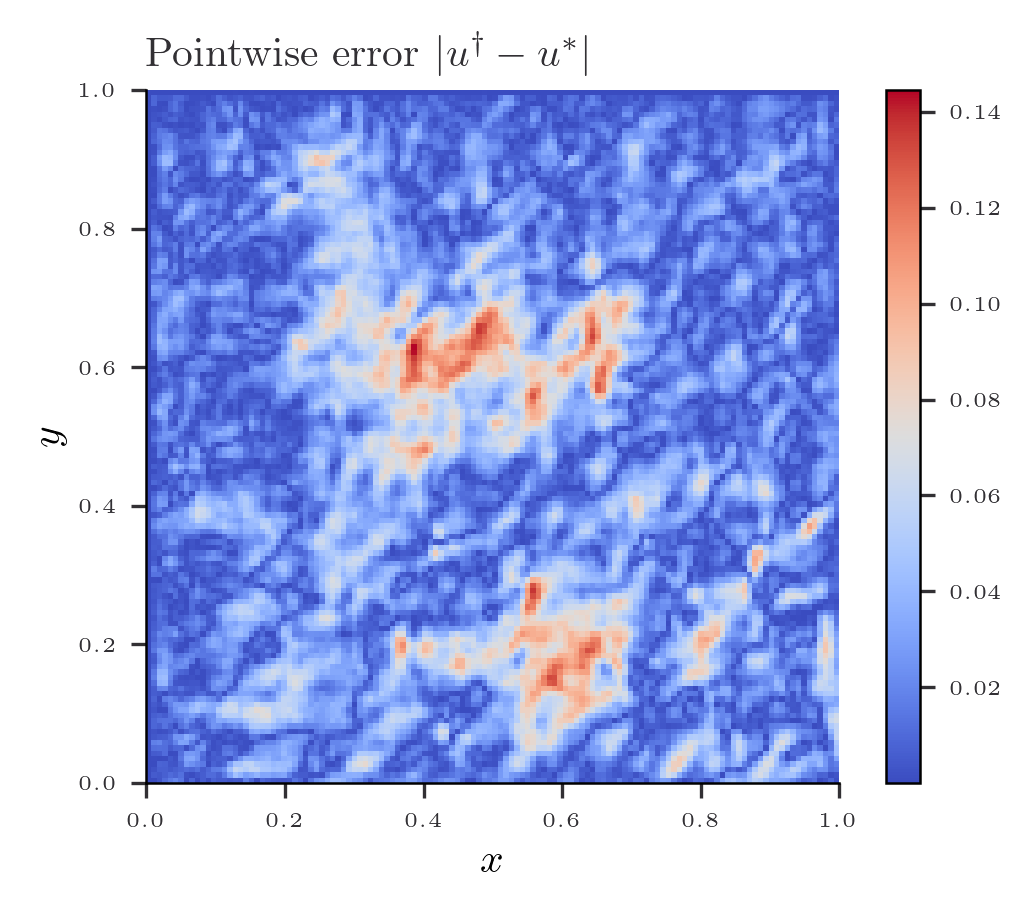

In [337]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# RFF embedding small + pointwise

In [344]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [345]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2

sigma_rff = 5.0
random_features = random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff


def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

Number of samples:  32


In [346]:
layer_sizes = [n_samples*2, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 3169 parameters in the neural network.


In [347]:
def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [348]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [349]:

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred = -nu*laplacian_grid + non_linearity
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [350]:
u_observed = evaluate_basis_sine_2d(x,y, coef_u)
f_observed =evaluate_basis_sine_2d(x,y, coef_laplacian) + vmap_b(x, y)*u_observed + tau(u_observed)

In [352]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

1389.2726176654344 [(Array([[  6.8697732 ,   4.15457145,  -9.2424881 , ...,  -1.06174607,
          0.95401662,  39.80408751],
       [  9.49736294,  -5.58172676,  12.19342286, ...,   8.85623237,
          2.75036307,   6.5463209 ],
       [ 15.71242615,  -9.37117935,  -6.80237764, ...,   8.45865799,
          7.3053501 ,   8.34024268],
       ...,
       [  0.13876642,  13.95599444,   9.53342289, ...,  -5.11108193,
        -12.39325683,  -5.56473054],
       [-19.85400815,  18.6468805 ,  20.50665658, ...,  19.66275064,
        -15.0079841 , -50.32711322],
       [  8.36778621,  -1.19566183,  -3.00388681, ...,  -4.46435503,
         11.0229186 ,   0.24134476]], dtype=float64), Array([-14.20088112,  -0.92719856,   3.78026663, -11.92688309,
         6.33891649, -17.35589193,   7.92910515,  -1.25022065,
        -0.67119504,  -7.64694627,  12.95355812, -15.07779369,
        -5.78372161,  27.48960152,   3.10898495, -12.99193249,
         5.20152077,   2.03299181,   5.71600489,   7.81112616,

In [353]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [354]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [355]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [356]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1389.2726177
Step 0, Training Loss: 1389.2726177, Learning Rate: 0.001000
Epoch 10000, Loss: 230.2254601
Step 10000, Training Loss: 230.2254601, Learning Rate: 0.000900
Epoch 20000, Loss: 206.1956582
Step 20000, Training Loss: 206.1956582, Learning Rate: 0.000810
Epoch 30000, Loss: 198.5691955
Step 30000, Training Loss: 198.5691955, Learning Rate: 0.000729
Epoch 40000, Loss: 193.5927933
Step 40000, Training Loss: 193.5927933, Learning Rate: 0.000656
Epoch 50000, Loss: 187.2230999
Step 50000, Training Loss: 187.2230999, Learning Rate: 0.000590
Epoch 60000, Loss: 183.5134744
Step 60000, Training Loss: 183.5134744, Learning Rate: 0.000531
Epoch 70000, Loss: 180.4518936
Step 70000, Training Loss: 180.4518936, Learning Rate: 0.000478
Epoch 80000, Loss: 177.1712421
Step 80000, Training Loss: 177.1712421, Learning Rate: 0.000430
Epoch 90000, Loss: 174.7007682
Step 90000, Training Loss: 174.7007682, Learning Rate: 0.000387


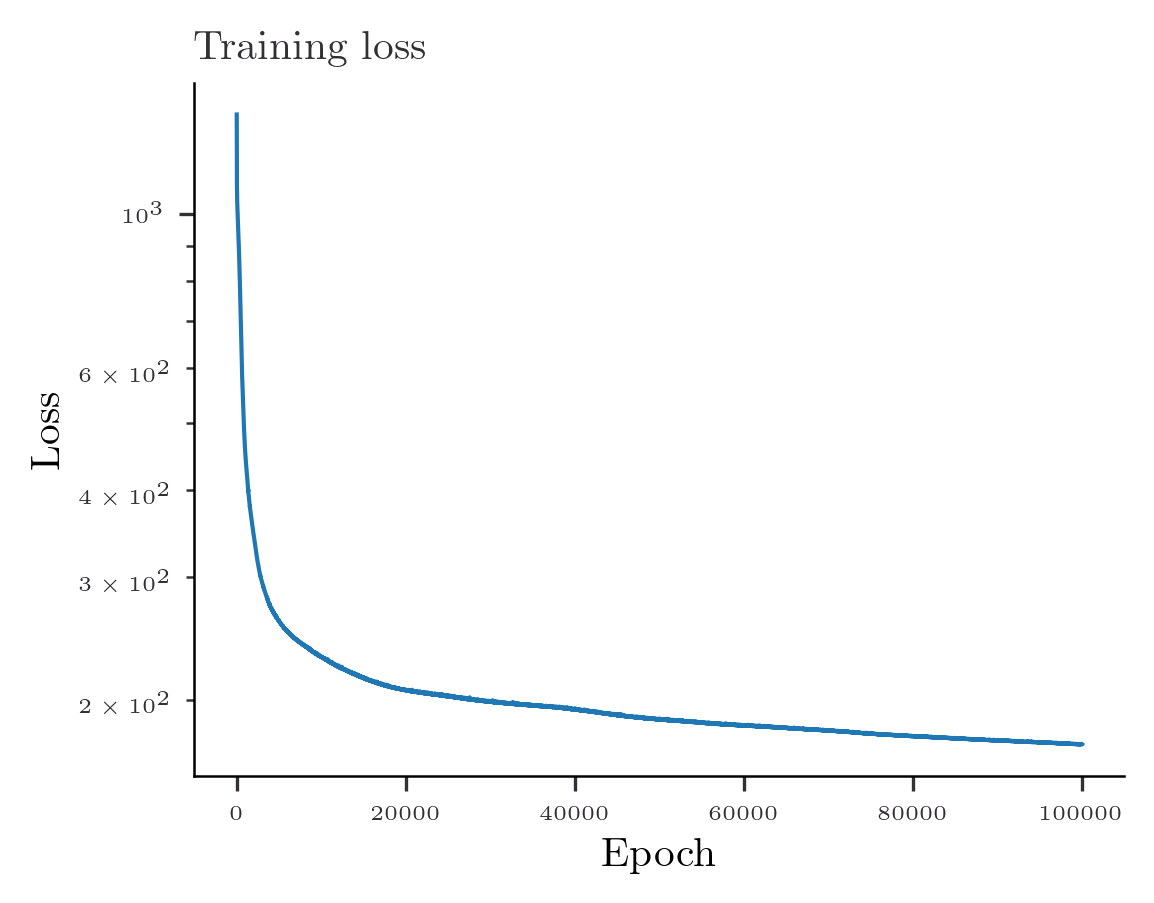

In [357]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [358]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [359]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [360]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.3959317, dtype=float64), Array(1.21893636, dtype=float64))


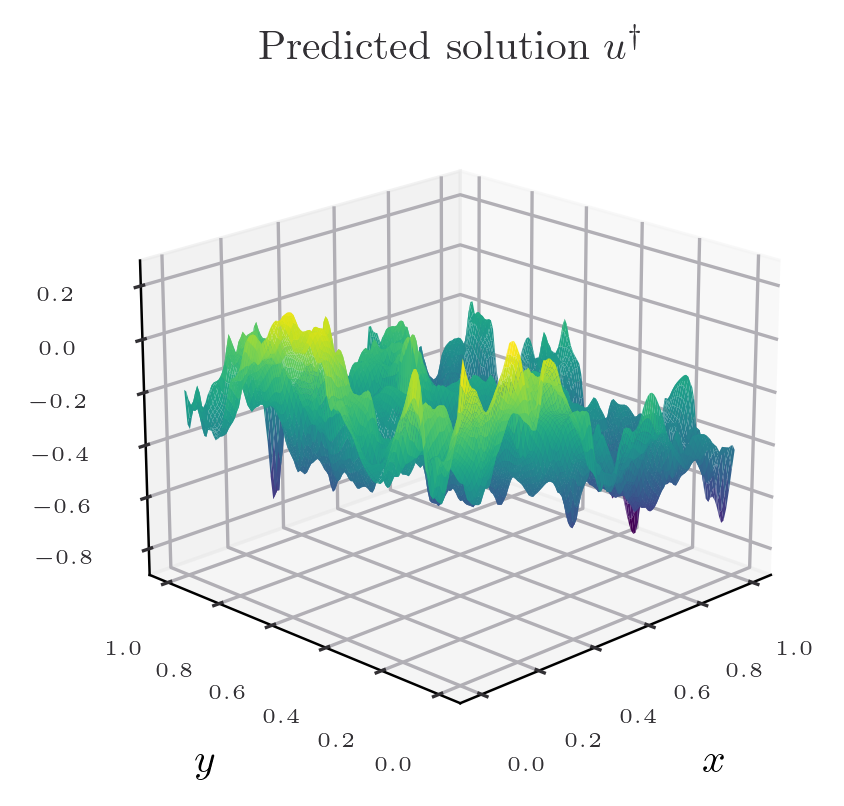

In [361]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

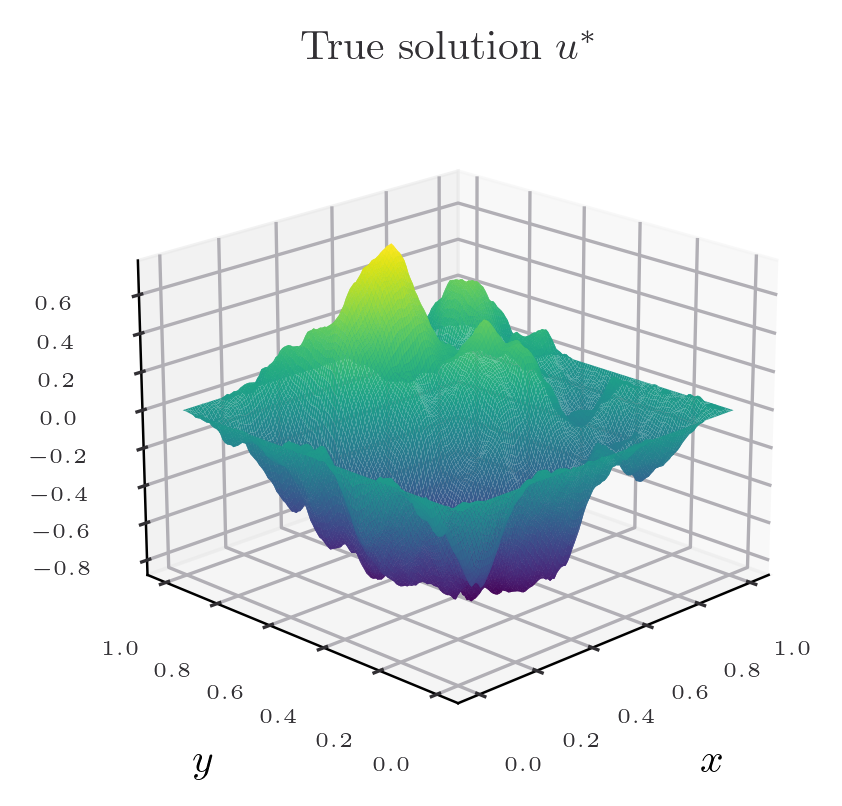

In [362]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

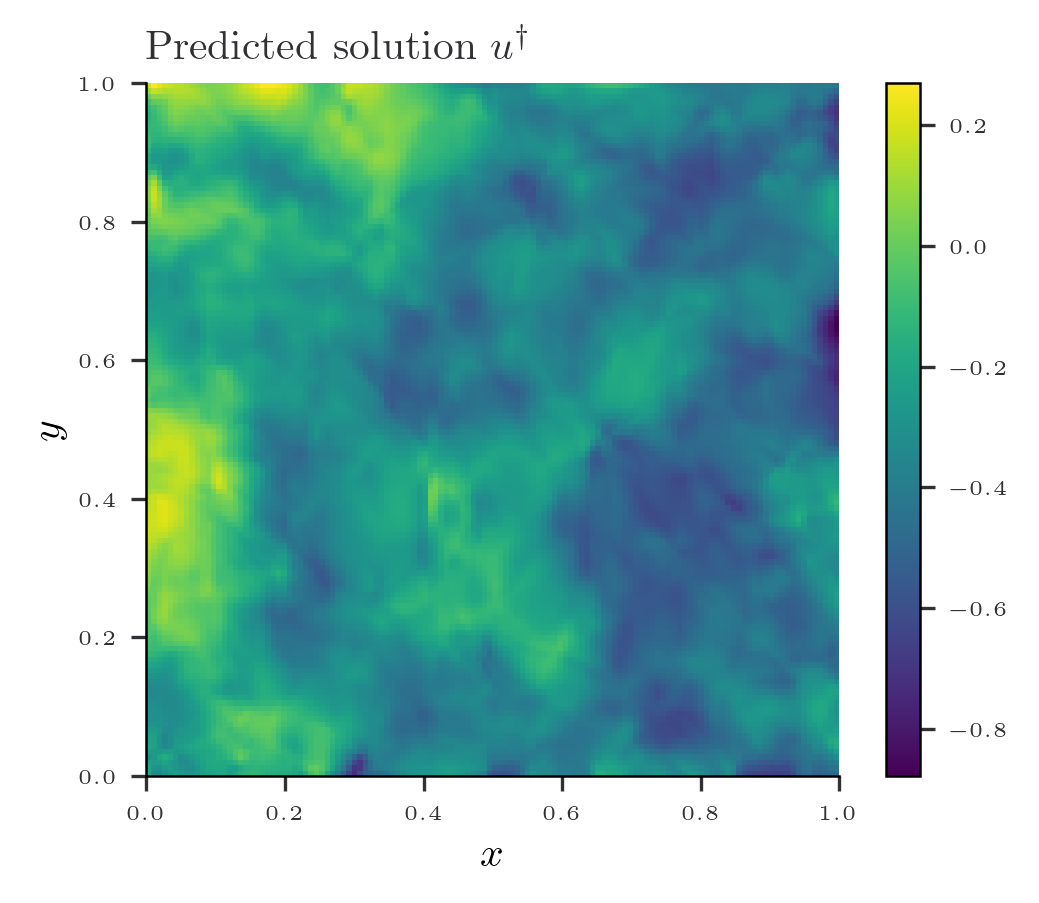

In [363]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

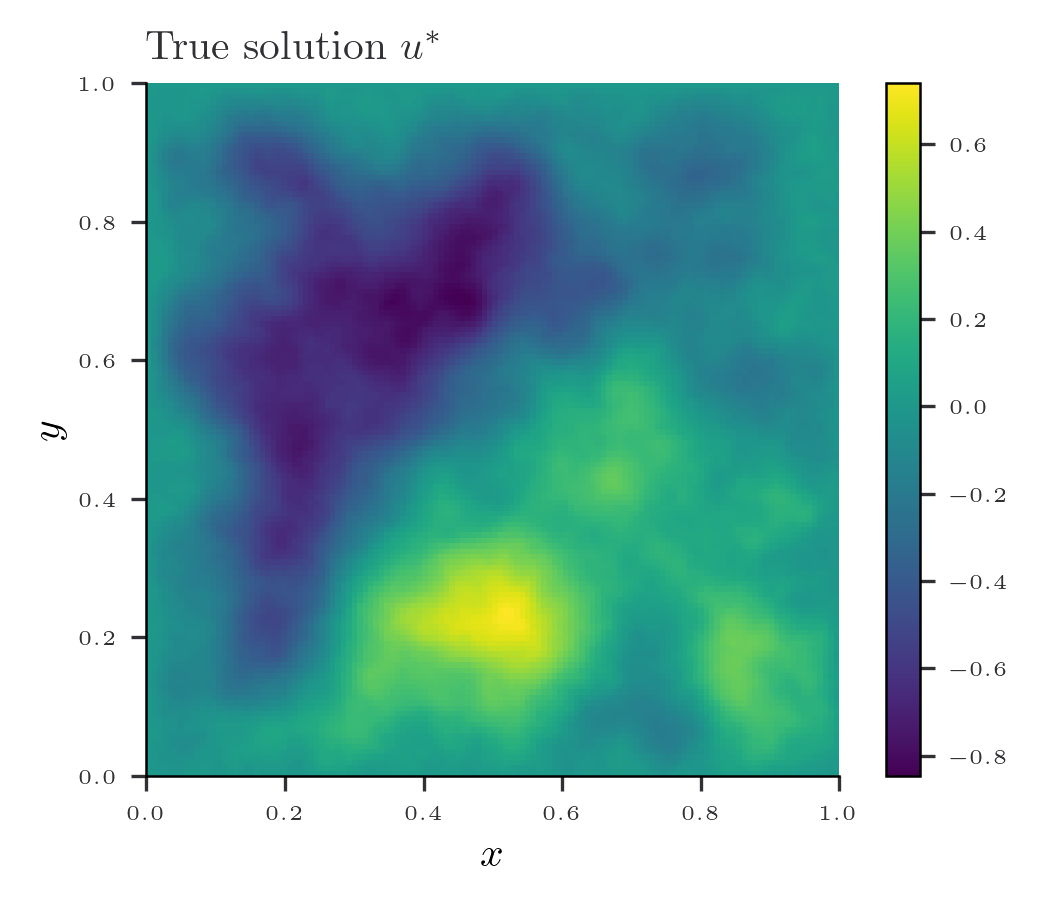

In [364]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

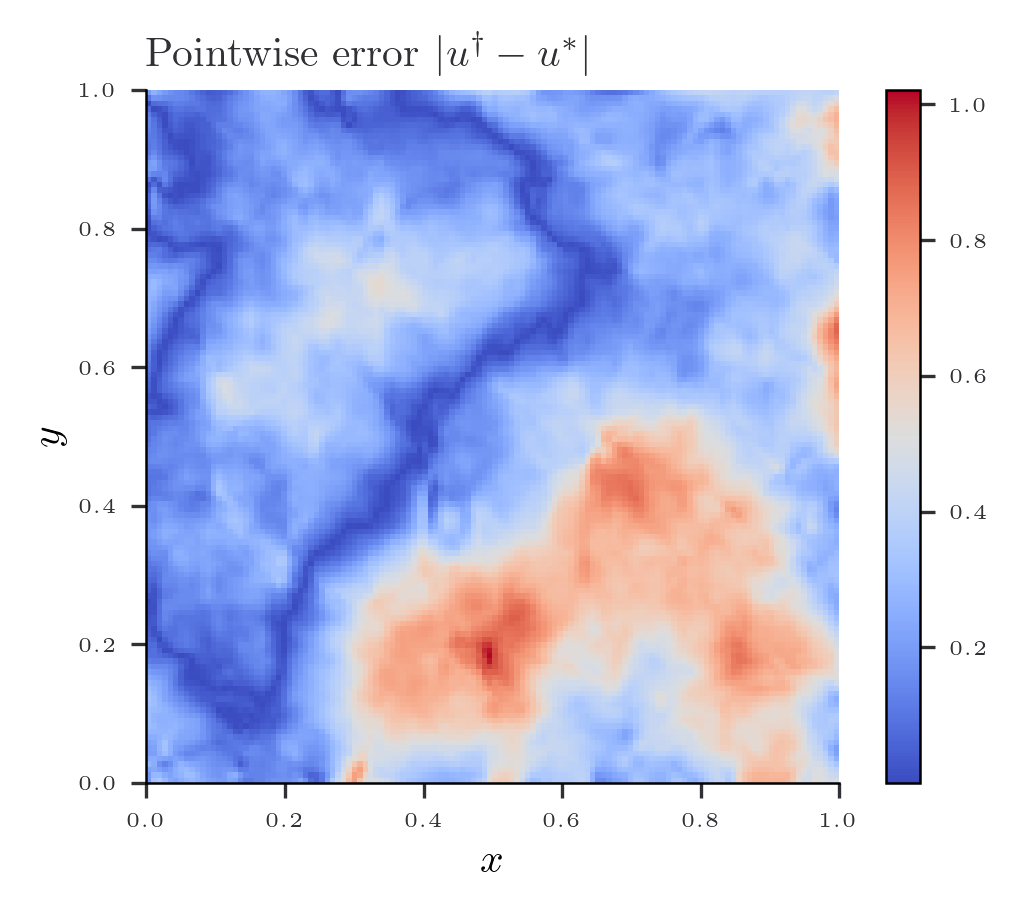

In [365]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Vanilla small + pointwise

In [367]:
layer_sizes = [2,32,  32, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 3297 parameters in the neural network.


In [368]:
def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [369]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [370]:

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred = -nu*laplacian_grid + non_linearity
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [371]:
u_observed = evaluate_basis_sine_2d(x,y, coef_u)
f_observed =evaluate_basis_sine_2d(x,y, coef_laplacian) + vmap_b(x, y)*u_observed + tau(u_observed)

In [372]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

1127.0565750643818 [(Array([[ 0.02066715, -0.16176078, -0.09431368, -0.00589585,  0.00303043,
         0.04252301,  0.04113247,  0.15774258,  0.19786548,  0.027939  ,
         0.11507748,  0.02894183, -0.32560822,  0.16528649,  0.03247114,
         0.01028545, -0.21368567,  0.08928795, -0.12358204, -0.27734063,
        -0.0626988 ,  0.05546053, -0.19207455,  0.11375638,  0.10983298,
         0.20166794, -0.04579146,  0.05360226, -0.03286524,  0.07678477,
        -0.04925566, -0.10055833],
       [-0.12065114, -0.13615744, -0.0918402 , -0.19677548, -0.12067519,
         0.01936207, -0.17556088,  0.06617167, -0.12463454,  0.01186998,
         0.14495604,  0.04105431, -0.41402502,  0.06544415,  0.04766333,
        -0.31907865, -0.42528994,  0.0050297 ,  0.13206477, -0.2126936 ,
        -0.19610314,  0.07619335, -0.26135237,  0.11252796,  0.31140423,
         0.15023449,  0.06792364, -0.04581278,  0.01805262,  0.11848722,
         0.3303623 , -0.1913274 ]], dtype=float64), Array([-0.158053

In [373]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [374]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [375]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [376]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1127.0565751
Step 0, Training Loss: 1127.0565751, Learning Rate: 0.001000
Epoch 10000, Loss: 716.6581156
Step 10000, Training Loss: 716.6581156, Learning Rate: 0.000900
Epoch 20000, Loss: 658.0770526
Step 20000, Training Loss: 658.0770526, Learning Rate: 0.000810
Epoch 30000, Loss: 627.5342985
Step 30000, Training Loss: 627.5342985, Learning Rate: 0.000729
Epoch 40000, Loss: 605.8067207
Step 40000, Training Loss: 605.8067207, Learning Rate: 0.000656
Epoch 50000, Loss: 584.1634779
Step 50000, Training Loss: 584.1634779, Learning Rate: 0.000590
Epoch 60000, Loss: 569.1768100
Step 60000, Training Loss: 569.1768100, Learning Rate: 0.000531
Epoch 70000, Loss: 555.7077150
Step 70000, Training Loss: 555.7077150, Learning Rate: 0.000478
Epoch 80000, Loss: 545.4404629
Step 80000, Training Loss: 545.4404629, Learning Rate: 0.000430
Epoch 90000, Loss: 536.7625696
Step 90000, Training Loss: 536.7625696, Learning Rate: 0.000387


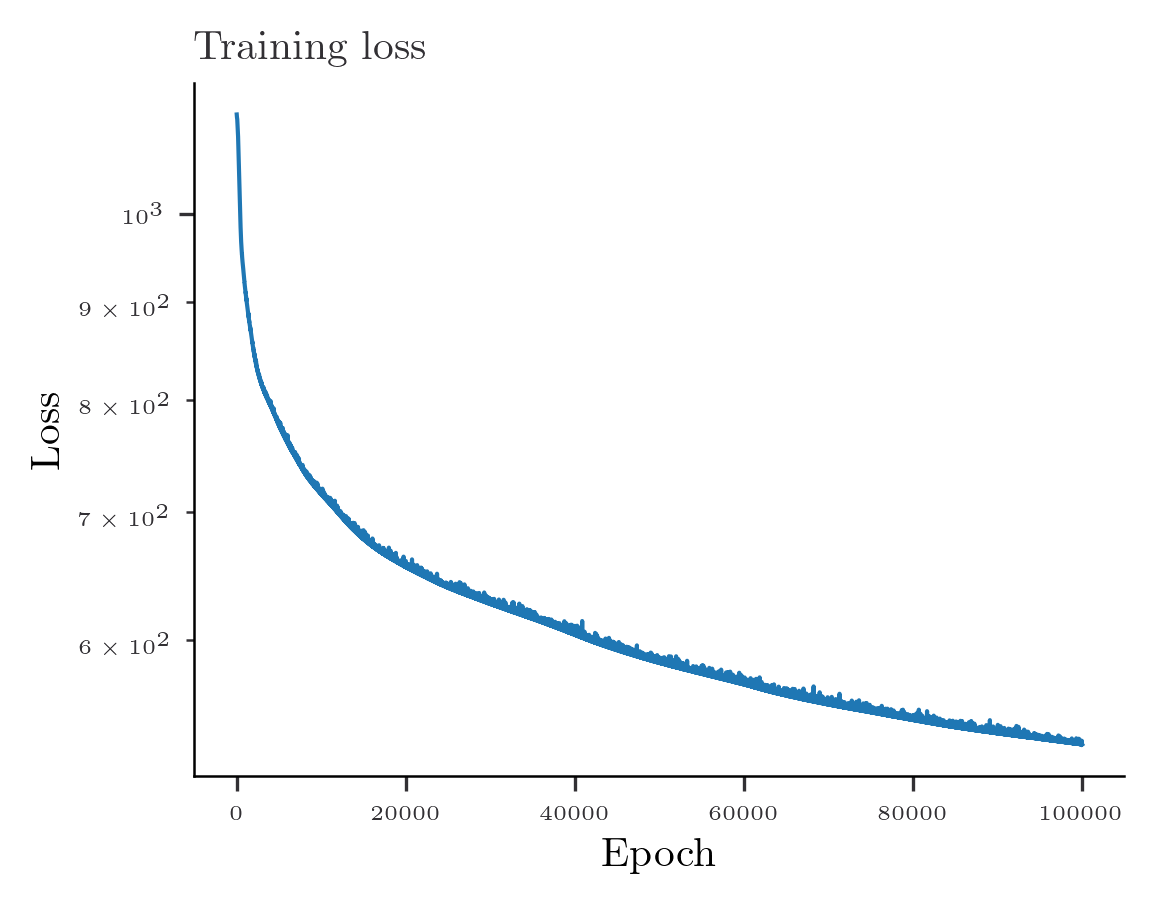

In [377]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [378]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [379]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [380]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.38146105, dtype=float64), Array(1.17438623, dtype=float64))


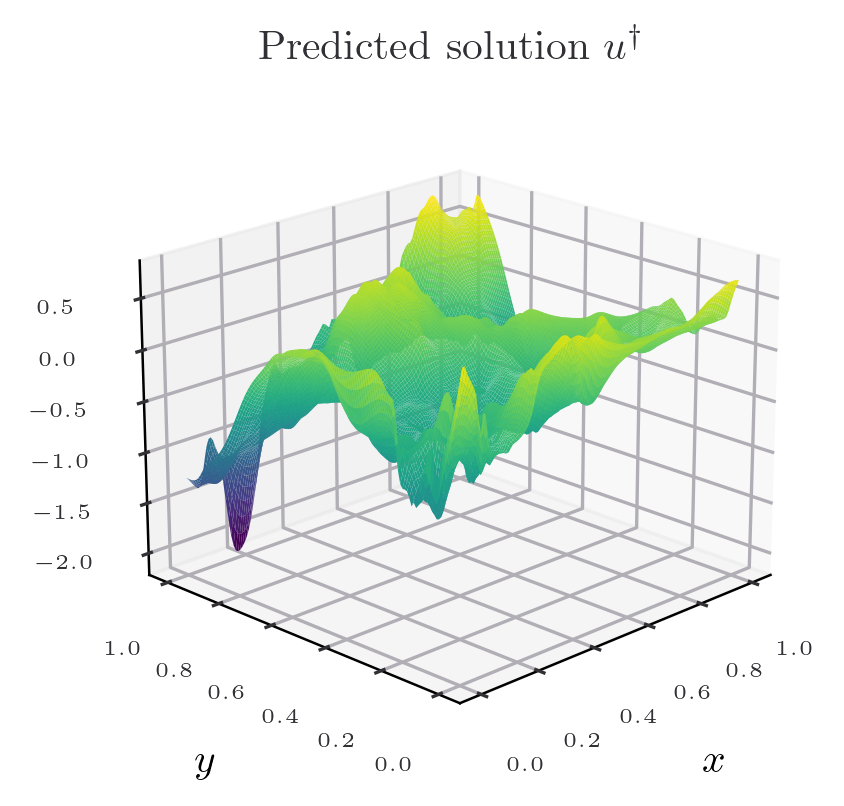

In [381]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

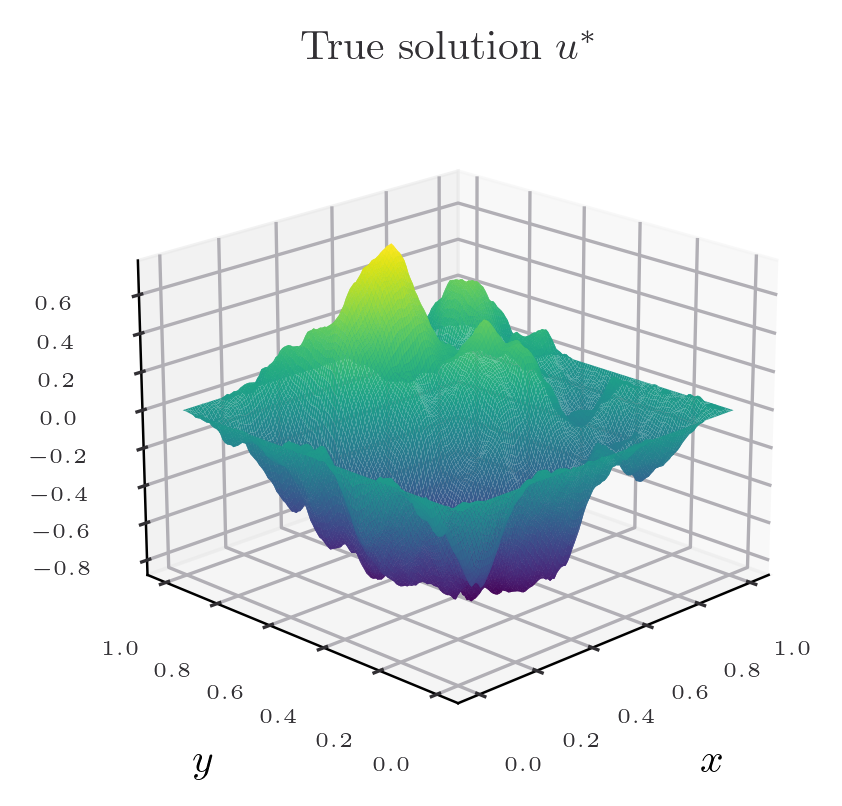

In [382]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

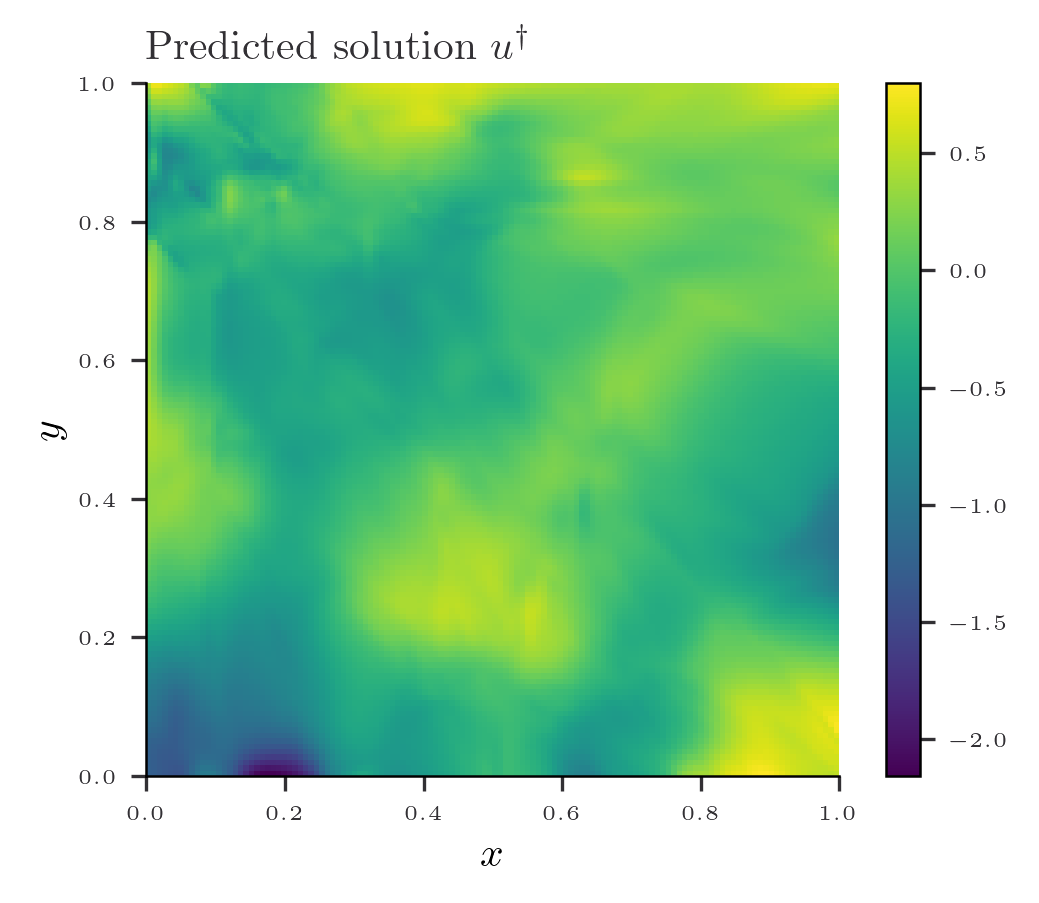

In [383]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

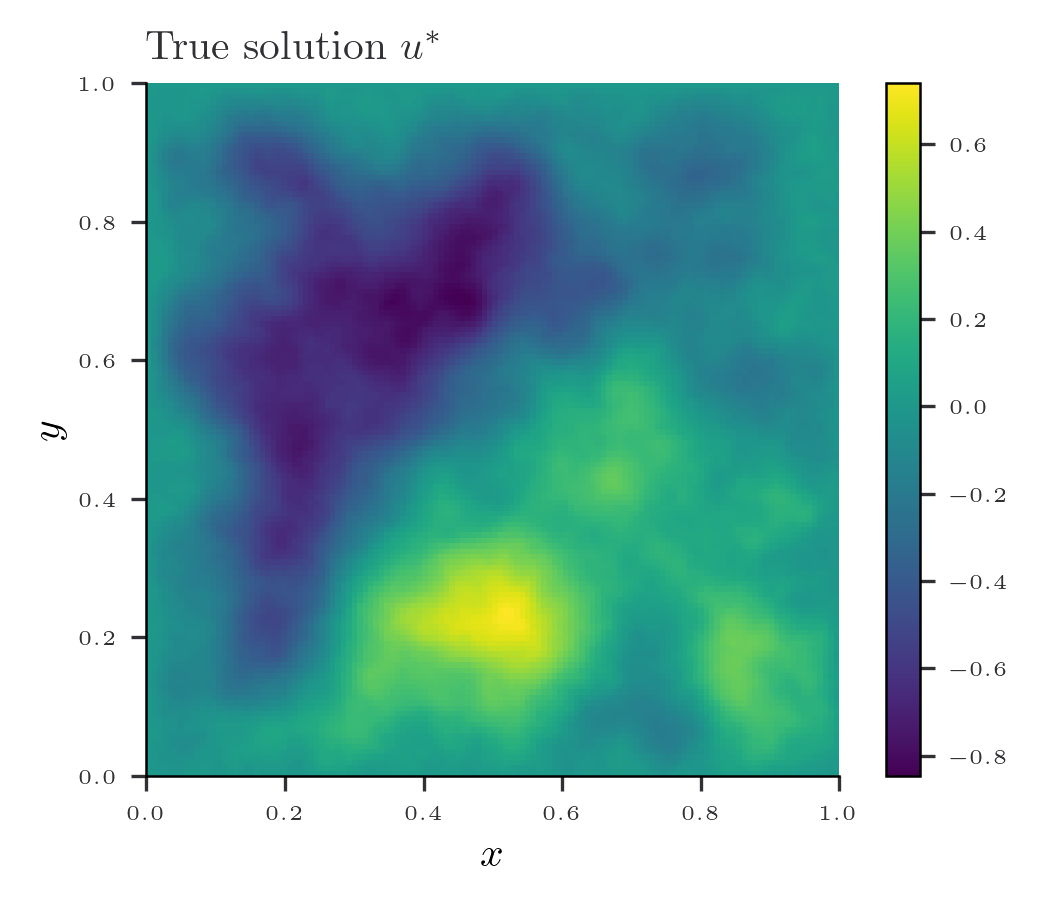

In [384]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

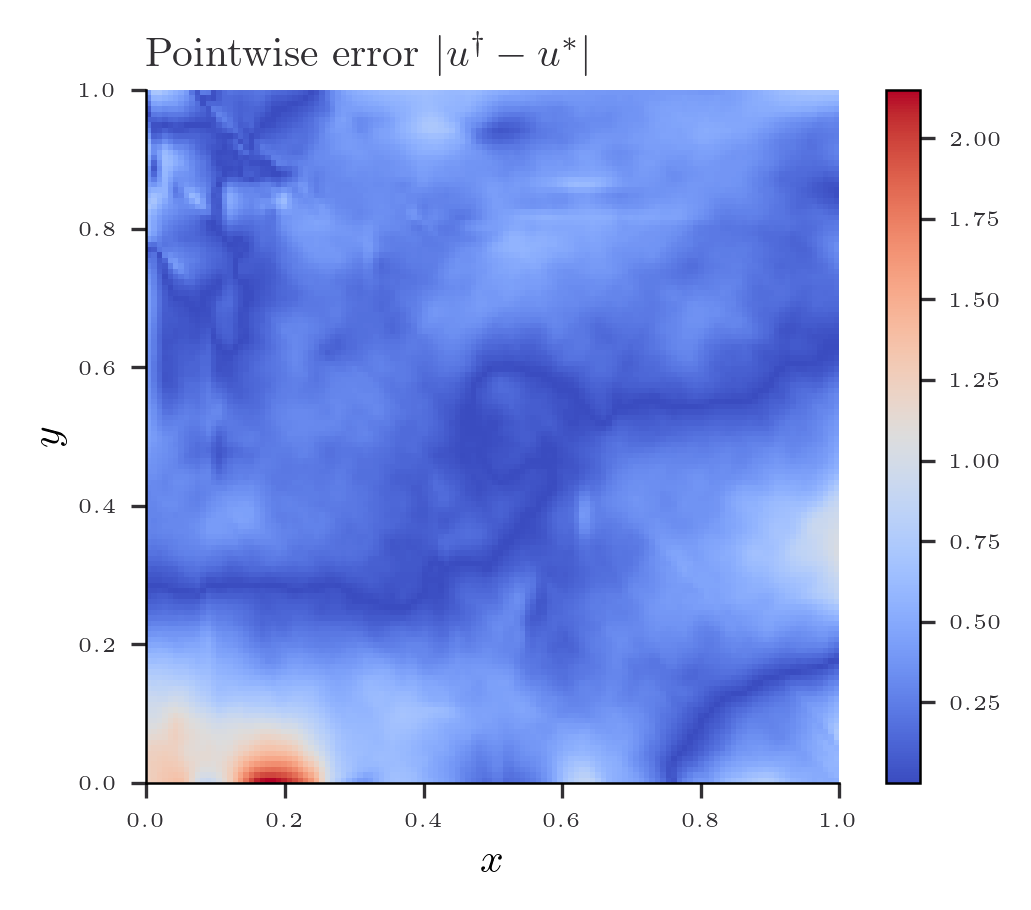

In [385]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# RFF embedding: student t

In [386]:
decay_nugget =  ((jnp.arange(0,n_points)[None]**2 + jnp.arange(0,n_points)[:,None]**2) + 1.0)**(-0.5)
decay_nugget

Array([[1.        , 0.70710678, 0.4472136 , ..., 0.01639124, 0.01612693,
        0.01587102],
       [0.70710678, 0.57735027, 0.40824829, ..., 0.01638904, 0.01612484,
        0.01586902],
       [0.4472136 , 0.40824829, 0.33333333, ..., 0.01638244, 0.01611855,
        0.01586303],
       ...,
       [0.01639124, 0.01638904, 0.01638244, ..., 0.01159114, 0.01149653,
        0.01140272],
       [0.01612693, 0.01612484, 0.01611855, ..., 0.01149653, 0.01140421,
        0.01131262],
       [0.01587102, 0.01586902, 0.01586303, ..., 0.01140272, 0.01131262,
        0.01122321]], dtype=float64, weak_type=True)

In [390]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 2
nu = 2.5
df= nu + d_in -1

sigma_rff = 1.0
random_features = random.t(random.PRNGKey(123),  df = df, shape = (n_samples, d_in))*sigma_rff #random.normal(random.PRNGKey(123),  shape = (n_samples, d_in))*sigma_rff


def feature_map(x, random_features):
    outputs = jnp.dot(random_features, x)
    return jnp.hstack([jnp.cos(outputs), jnp.sin(outputs)])

Number of samples:  32


In [394]:
layer_sizes = [n_samples*2, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

There are 8385 parameters in the neural network.


In [395]:
def predict(params, x):
    activations = feature_map(x, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [396]:
neural_network = jit(vmap(predict, in_axes=(None, 0)))
def laplacian(params, x):
    return jnp.trace(hessian(predict, argnums=-1)(params, x))
nn_laplacian = jit(vmap(laplacian, in_axes = (None, 0)))

In [397]:

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, n_points, w = 1.0):
    u_grid = neural_network(params, grid).reshape(n_points, n_points)
    non_linearity = tau(u_grid)
    laplacian_grid = nn_laplacian(params, grid).reshape(n_points, n_points)
    # Compute the sine transform
    pred_sine = dst_2d(-nu*laplacian_grid + non_linearity)
    residual_interior = (pred_sine - f)*decay_nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [398]:
f_observed =  f_trans[:n_points,:n_points]
f_observed

Array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.41736873, -1.02813593, ..., -0.203404  ,
         0.22311882,  0.43977695],
       [-0.        , -1.43503363, -0.02708068, ...,  0.32359806,
         0.26815807,  0.02972378],
       ...,
       [-0.        , -0.14150558,  0.28232389, ...,  0.00510233,
        -0.16417319, -0.22525732],
       [-0.        , -0.14378408,  0.08899411, ...,  0.23014135,
         0.02384538, -0.04441765],
       [-0.        ,  0.13261293,  0.20310402, ..., -0.14327253,
         0.16327559, -0.09289254]], dtype=float64)

In [399]:
loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points, w = 1.0)
print(loss, grads)

0.1173765770500251 [(Array([[ 0.00289068, -0.00937732, -0.00125367, ...,  0.01020755,
         0.00253651, -0.00067251],
       [-0.00374131, -0.01978227,  0.00082542, ...,  0.01096761,
        -0.00384965,  0.01564136],
       [-0.00443483, -0.01959328,  0.00074336, ...,  0.01063792,
        -0.0036279 ,  0.01615626],
       ...,
       [-0.00167996, -0.01457094, -0.00221384, ...,  0.01017963,
         0.00208389,  0.00834687],
       [ 0.00964799, -0.02309959, -0.00730605, ...,  0.02399417,
         0.01231287, -0.00247387],
       [ 0.0005047 ,  0.00283649,  0.00043777, ..., -0.00196262,
        -0.00034152, -0.00174894]], dtype=float64), Array([-4.52649991e-03, -1.95883274e-02,  7.37133271e-04, -6.50234993e-03,
       -7.53141666e-02, -1.82789125e-02,  3.03138043e-03, -4.02957351e-02,
        5.00132300e-03,  2.04005766e-02, -6.11840746e-02, -1.74717047e-02,
       -2.98504896e-02,  1.75193551e-02,  4.10478088e-04,  4.22694905e-04,
       -2.23277219e-02, -1.85378122e-02, -8.397511

In [400]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [401]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, interior, boundary_points, f_observed, boundary_condition, nu, n_points)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [402]:
patience = jnp.inf  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [403]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
        #best_param = params.copy()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1173766
Step 0, Training Loss: 0.1173766, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0001067
Step 10000, Training Loss: 0.0001067, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0000828
Step 20000, Training Loss: 0.0000828, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0000677
Step 30000, Training Loss: 0.0000677, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0000634
Step 40000, Training Loss: 0.0000634, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0000501
Step 50000, Training Loss: 0.0000501, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0000445
Step 60000, Training Loss: 0.0000445, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0000408
Step 70000, Training Loss: 0.0000408, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0000379
Step 80000, Training Loss: 0.0000379, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0000357
Step 90000, Training Loss: 0.0000357, Learning Rate: 0.000387


In [404]:
loss

Array(3.44879787e-05, dtype=float64)

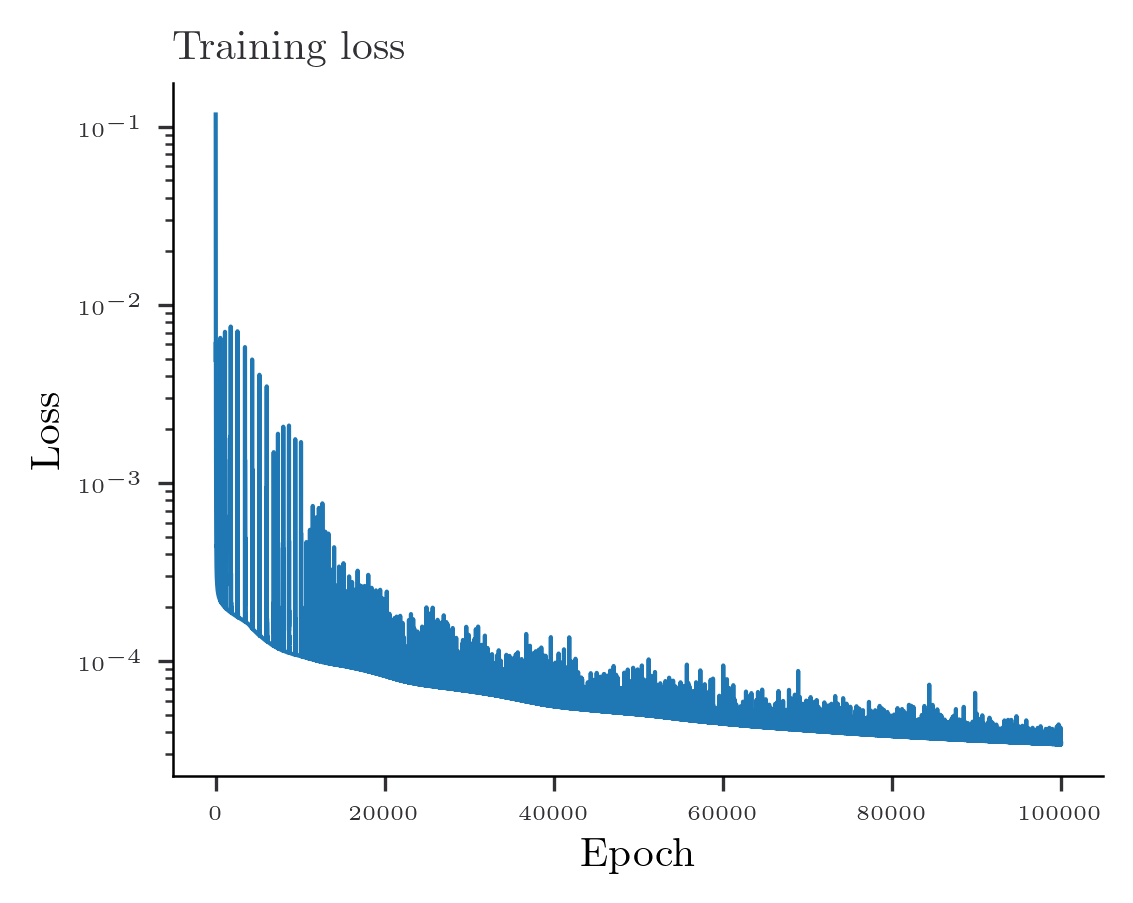

In [405]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [406]:
n_eval = n_coef
x_eval = jnp.linspace(lower, upper, n_eval)
y_eval = jnp.linspace(lower, upper, n_eval)
X, Y = jnp.meshgrid(x_eval, y_eval)
interior_eval = create_interior(x_eval, y_eval)
u_eval =evaluate_basis_sine_2d(x_eval,y_eval, coef_u)

In [407]:
pred_grid = neural_network(params, interior_eval).reshape(n_eval, n_eval)

In [408]:
print(compute_2d_error(pred_grid, u_eval, x_eval, y_eval))

(Array(0.30805858, dtype=float64), Array(0.94840549, dtype=float64))


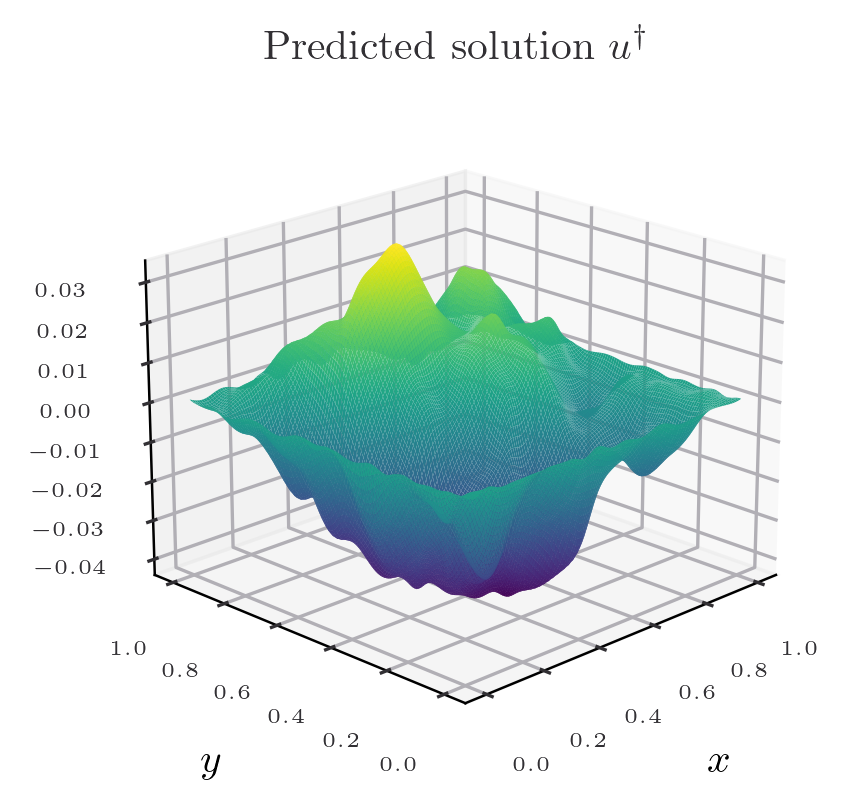

In [409]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, pred_grid,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"Predicted solution $u^\dagger$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

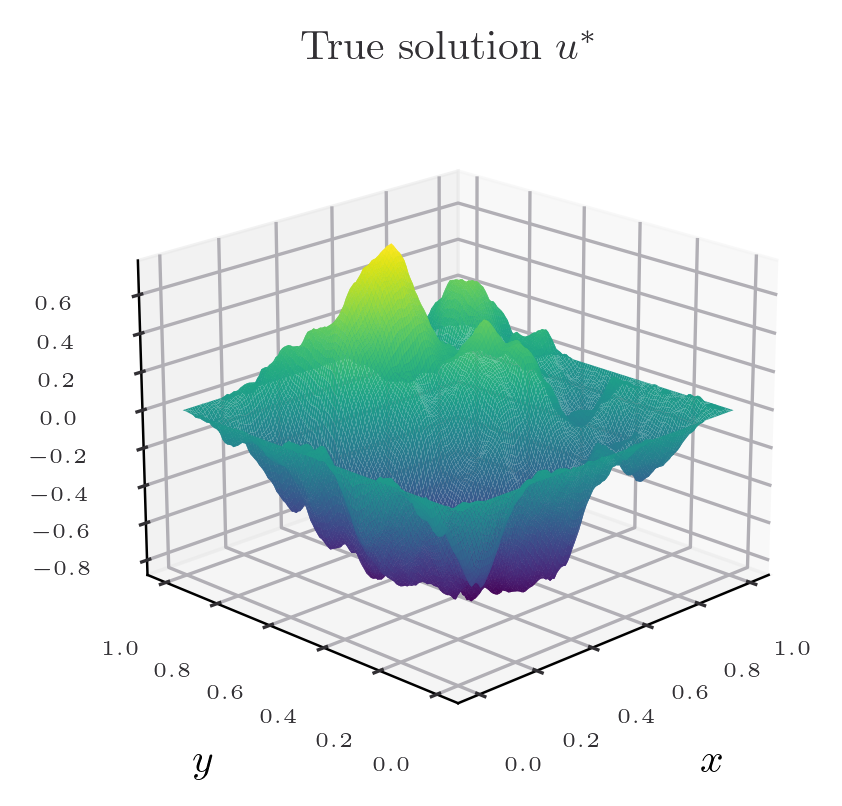

In [410]:
# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

stride = 1
ax.plot_surface(X, Y, u_eval,  cmap='viridis', rstride=stride, cstride=stride)
ax.set_title(r"True solution $u^*$")
ax.view_init(elev=20, azim=225)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

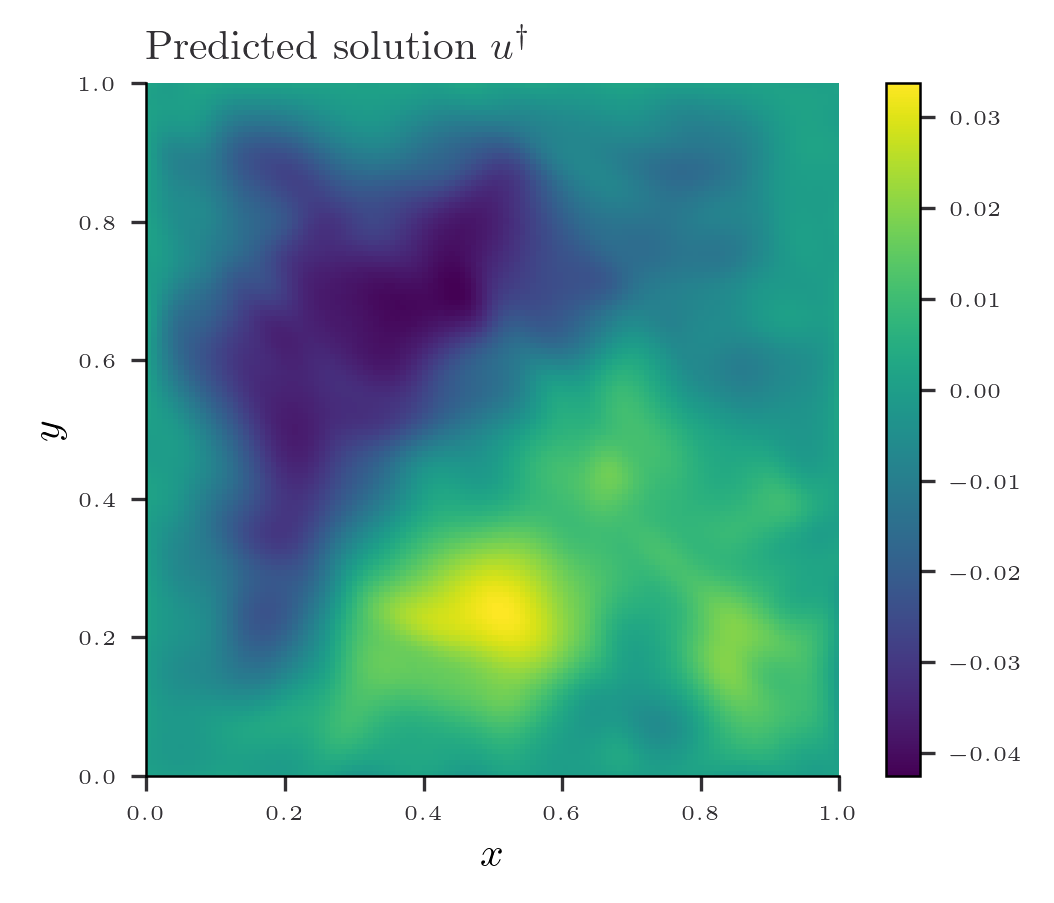

In [411]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_grid, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Predicted solution $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

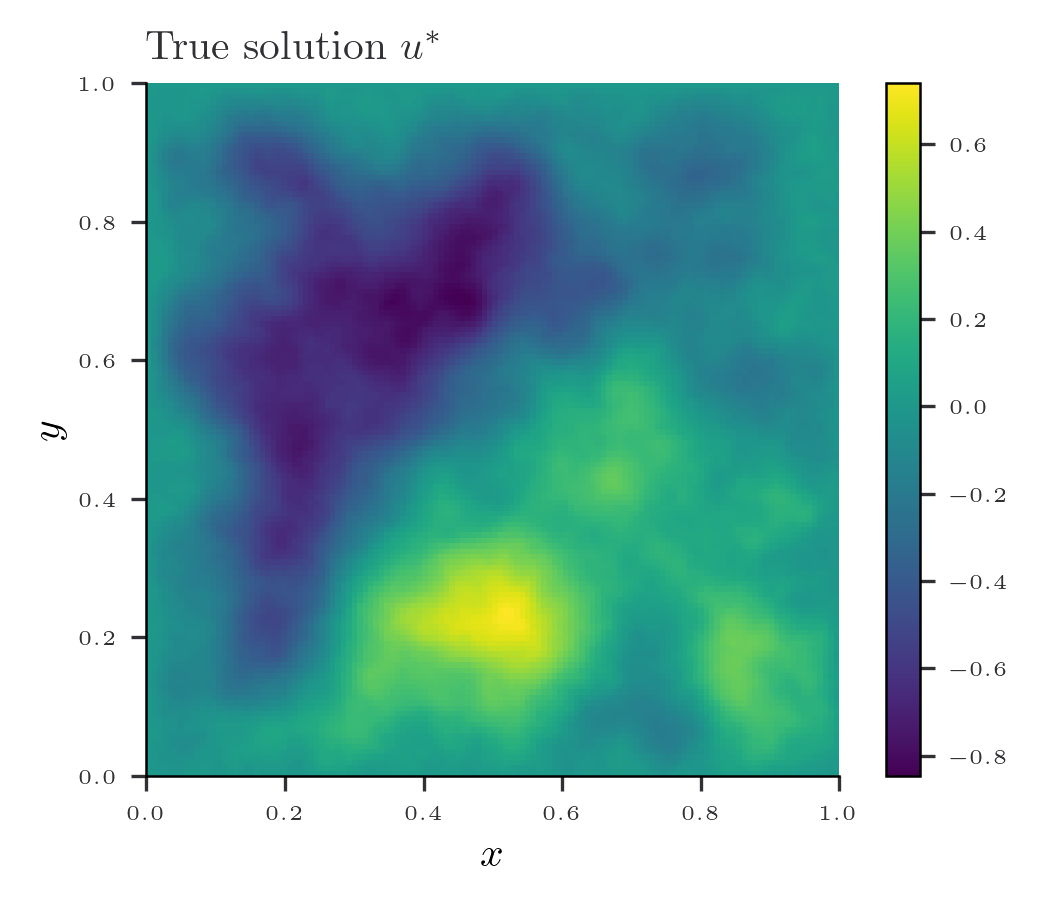

In [412]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values, cmap='viridis', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'True solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

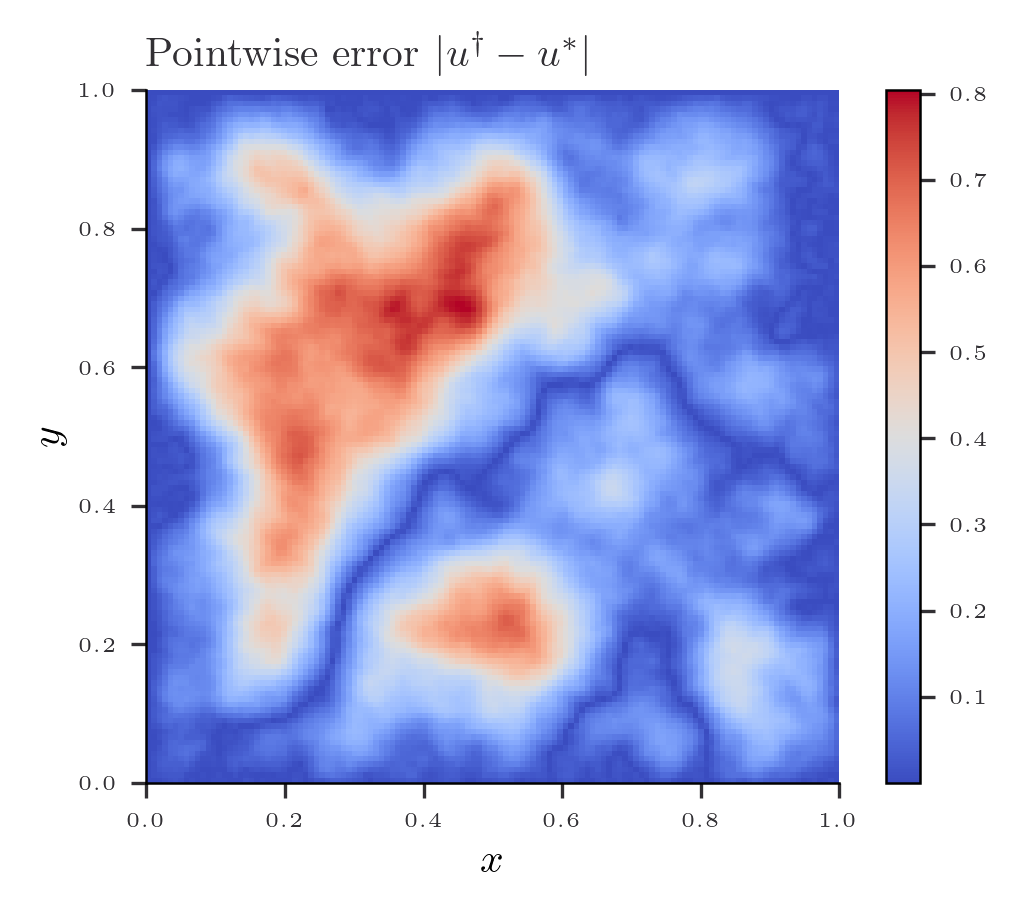

In [413]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_grid - u_values), cmap='coolwarm', extent=[x_eval.min(), x_eval.max(), y_eval.min(), y_eval.max()])

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()